In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import glob
import re
import scipy.io as sp
import csv
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import re
import math

In [2]:
pd.set_option('display.max_columns', 100)
sc.settings.set_figure_params(dpi=80)

In [3]:
projectDir="/scratch/projects/HTAPP_MBC/"
baseDir=projectDir+"/"+"phase2"
codeDir="/secure/projects/HTAPP_MBC"
dataDir=baseDir+"/pipeline/alignreads/"
out_dir=projectDir+"/spatial/coordination/"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [4]:
#see definition in spatial_utils -> needed for bin sizes
microns={"slide_seq": 5000/3000,"exseq": 1/0.051,"exseq_bin": 1/0.051,"merfish":1,"merfish_bin":1,"codex":1/0.386}

In [5]:
sample_sheet=pd.read_csv(codeDir+"/meta/sampletracking_HTAPP_MBC_spatial.csv")
sample_sheet['sample_ID']=sample_sheet['sample']+'_'+sample_sheet['replicate'].astype(str)
sample_sheet.head()

sample  replicate     batch  puck slide_seq_ID  \
0  HTAPP-944-SMP-7479          1  200213.0   3.0    200213_03   
1  HTAPP-944-SMP-7479          2       NaN   NaN          NaN   
2  HTAPP-944-SMP-7479          3       NaN   NaN          NaN   
3  HTAPP-895-SMP-7359          1  200213.0   5.0    200213_05   
4  HTAPP-880-SMP-7179          1  200316.0   5.0    200316_05   

              sample_ID  
0  HTAPP-944-SMP-7479_1  
1  HTAPP-944-SMP-7479_2  
2  HTAPP-944-SMP-7479_3  
3  HTAPP-895-SMP-7359_1  
4  HTAPP-880-SMP-7179_1

### Create output folders

In [22]:
for sample in sample_sheet['sample'].unique():
    print(sample)
    save_dir=out_dir+"/"+sample
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    else:
        print("Folder exists")

HTAPP-944-SMP-7479
HTAPP-895-SMP-7359
HTAPP-880-SMP-7179
HTAPP-878-SMP-7149
HTAPP-812-SMP-8239
HTAPP-514-SMP-6760
HTAPP-982-SMP-7629
HTAPP-997-SMP-7789
HTAPP-917-SMP-4531
HTAPP-853-SMP-4381
HTAPP-313-SMP-932
HTAPP-330-SMP-1082
HTAPP-783-SMP-4081
HTAPP-364-SMP-1321
HTAPP-213-SMP-6752


### Save clinical annotations

In [8]:
all_annot=pd.read_csv(projectDir+"/phase2/PyCache/fresh_frozen_combined_obs.tsv",sep="\t",low_memory=False)

In [15]:
for col in all_annot.columns:
    print(col,end=' ')

cellid batch cell_id name condition replicate orig.ident nCount_RNA nFeature_RNA percent.mito RNA_snn_res.0.8 seurat_clusters labels labels_score labels_unif labels_cl labels_cl_unif ccpm Quality Order run status Note date run_pipeline Channel Name Lane Index cancer site reference chemistry flowcell seq_dir mode min_umis min_genes percent_mito expected_cells total_droplets z_dim z_layers channel_id label_concordance labels_cl_unif_per_channel filt_median_genes filt_median_umi pass ccpm_id ccpm_id_long sample htapp sequenced annotated fresh frozen path_tumor_present cohort stage_at_diagnosis metastatic_presentation biopsy_days_after_dob biopsy_days_after_diagnosis biopsy_days_after_metastasis prior_lines_tx_metastatic prior_lines_tx_total ER_primary_fraction ER_primary ER_biopsy_fraction ER_biopsy ER_concordance PR_primary_fraction PR_primary PR_biopsy_fraction PR_biopsy PR_concordance HER2_primary HER2_biopsy HER2_concordance receptors_primary receptors_biopsy site_biopsy site_biopsy_d

In [27]:
annot_red=all_annot.loc[all_annot.name.isin(sample_sheet["sample"]),['name','condition','stage_at_diagnosis', 'metastatic_presentation','ER_primary','ER_biopsy', 'PR_primary', 'PR_biopsy','HER2_primary', 'HER2_biopsy', 'receptors_primary', 'receptors_biopsy', 'site_biopsy']].drop_duplicates().reset_index(drop=True)

In [28]:
annot_red.head()

name condition stage_at_diagnosis metastatic_presentation  \
0  HTAPP-944-SMP-7479       TST                 IA               Recurrent   
1  HTAPP-514-SMP-6760       TST                 IV                 De novo   
2  HTAPP-895-SMP-7359       TST                 IB               Recurrent   
3  HTAPP-213-SMP-6752       TST               IIIC               Recurrent   
4  HTAPP-878-SMP-7149       TST                IIA               Recurrent   

  ER_primary ER_biopsy PR_primary PR_biopsy HER2_primary HER2_biopsy  \
0   Positive  Positive   Positive  Negative     Negative    Negative   
1   Negative  Negative   Negative  Negative     Negative    Negative   
2    Unknown  Positive    Unknown  Positive      Unknown    Negative   
3   Negative  Negative   Negative  Negative     Negative    Negative   
4   Positive  Positive   Positive  Negative     Negative    Negative   

  receptors_primary receptors_biopsy site_biopsy  
0     ER+/PR+/HER2-    ER+/PR-/HER2-       Liver  
1               NaN    ER-/PR-/HER2-      Axilla  
2           Unknown    ER+/PR+/HER2-       Liver  
3     ER-/PR-/HER2-    ER-/PR-/HER2-  Chest wall  
4     ER+/PR+/HER2-    ER+/PR-/HER2-      Axilla

In [29]:
annot_red.to_csv(out_dir+"/HTAPP_MBC_spatial_annotations.tsv",sep="\t")

### Save the sc/sn data to the coordination folder

In [13]:
#cacheName="frozen_TST"
cacheName="fresh"

In [14]:
adata_big=sc.read_h5ad(baseDir+"/PyCache/"+cacheName+"_selected.h5ad")

In [15]:
overwrite=True
for sample in sample_sheet['sample'].unique():
    print(sample)
    
    counts_file=out_dir+"/"+sample+"/"+sample+"_scRNAseq_counts.tsv.gz"
    annot_file=out_dir+"/"+sample+"/"+sample+"_scRNAseq_annot.tsv.gz"
    adata_file=out_dir+"/"+sample+"/"+sample+"_scRNAseq.h5ad"
    
    if (os.path.exists(counts_file)&os.path.exists(annot_file)&os.path.exists(adata_file)&(overwrite==False)):
        print("Already there.")
        continue
    if not sample in adata_big.obs.name.values:
        print("Not found.")
        continue
    
    sub=adata_big[adata_big.obs.name==sample]
    annot=sub.obs[["replicate","condition","cell_type","labels_unif","labels_cl_unif","labels_cl_unif2_broad","compartments","cnv_pass_mal","Phase","n_genes_by_counts","total_counts","pct_counts_mt"]]
    annot.index.set_names(None,inplace=True)
    
    #create new object
    adata=anndata.AnnData(X=sub.obsm['counts'],var=sub.raw.var,obs=annot)
    sc.pp.filter_genes(adata, min_cells=3)
    
    counts=pd.DataFrame(adata.X.T.astype(int).toarray(),columns=adata.obs_names.rename(None),index=adata.var_names)
    counts.to_csv(counts_file,sep="\t",compression="gzip") #super slow
    annot.to_csv(annot_file,sep="\t",compression="gzip")
    adata.write(adata_file,compression="gzip")

HTAPP-944-SMP-7479
Not found.
HTAPP-895-SMP-7359
Not found.
HTAPP-880-SMP-7179
Not found.
HTAPP-878-SMP-7149
Not found.
HTAPP-812-SMP-8239
HTAPP-514-SMP-6760
Not found.
HTAPP-982-SMP-7629
HTAPP-997-SMP-7789
Not found.
HTAPP-917-SMP-4531
HTAPP-853-SMP-4381
HTAPP-313-SMP-932
HTAPP-330-SMP-1082
HTAPP-783-SMP-4081
HTAPP-364-SMP-1321
HTAPP-213-SMP-6752
Not found.


#### Example outputs

In [28]:
annot.head()

cell_type labels_unif  ...  \
HTAPP-213-SMP-6752-TST-channel1_GACGTTAGTTTCACTT-1       MBC  Epithelial  ...   
HTAPP-213-SMP-6752-TST-channel1_ATTCGTTAGCTTGTGT-1       MBC  Epithelial  ...   
HTAPP-213-SMP-6752-TST-channel1_AGAAGTAAGACCATAA-1       MBC  Epithelial  ...   
HTAPP-213-SMP-6752-TST-channel1_TGCGGGTCACAATGAA-1       MBC  Epithelial  ...   
HTAPP-213-SMP-6752-TST-channel1_TGGGCTGCAGCAGAAC-1       MBC  Epithelial  ...   

                                                   total_counts pct_counts_mt  
HTAPP-213-SMP-6752-TST-channel1_GACGTTAGTTTCACTT-1      19240.0     11.148648  
HTAPP-213-SMP-6752-TST-channel1_ATTCGTTAGCTTGTGT-1      19986.0      7.760432  
HTAPP-213-SMP-6752-TST-channel1_AGAAGTAAGACCATAA-1      19562.0      7.632144  
HTAPP-213-SMP-6752-TST-channel1_TGCGGGTCACAATGAA-1      19475.0      6.392811  
HTAPP-213-SMP-6752-TST-channel1_TGGGCTGCAGCAGAAC-1      19628.0      3.163848  

[5 rows x 9 columns]

In [29]:
counts.head()

HTAPP-213-SMP-6752-TST-channel1_GACGTTAGTTTCACTT-1  \
AL627309.1                                                  1    
AC114498.1                                                  0    
AL669831.2                                                  0    
AL669831.5                                                  1    
FAM87B                                                      0    

            HTAPP-213-SMP-6752-TST-channel1_ATTCGTTAGCTTGTGT-1  ...  \
AL627309.1                                                  0   ...   
AC114498.1                                                  0   ...   
AL669831.2                                                  0   ...   
AL669831.5                                                  0   ...   
FAM87B                                                      0   ...   

            HTAPP-213-SMP-6752-TST-channel2_CGGGTCATCGAGCCAC-1  \
AL627309.1                                                  0    
AC114498.1                                                  0    
AL669831.2                                                  0    
AL669831.5                                                  0    
FAM87B                                                      0    

            HTAPP-213-SMP-6752-TST-channel2_CAGGCCAGTTGGACCC-1  
AL627309.1                                                  0   
AC114498.1                                                  0   
AL669831.2                                                  0   
AL669831.5                                                  0   
FAM87B                                                      0   

[5 rows x 9716 columns]

In [30]:
adata

AnnData object with n_obs × n_vars = 9716 × 25065
    obs: 'cell_type', 'labels_unif', 'labels_cl_unif', 'compartments', 'cnv_pass_mal', 'Phase', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Save HE images to the coordination folder 

In [5]:
import shutil as sh
import re

In [7]:
def get_he(dir,suffix,n,r):
    he_dir=projectDir+"spatial/" + dir
    he_file=sample_dir+"/"+sample+"_HE_"+suffix
    source_glob=glob.glob(he_dir+'/'+ "HTAPP?"+n+"*", recursive=False)
     
    if (r==2):
        r="[267]"
    r = re.compile(".*[Ss][Ee][TtCc].*"+str(r))
    source_file = list(filter(r.match, source_glob))
    return([source_file,he_file])
    


for sample in sample_sheet['sample_ID']:
    print(sample)
    sheet_sub=sample_sheet[sample_sheet.sample_ID==sample].iloc[0]
    sample_dir=out_dir+"/"+sheet_sub['sample']
    
    n=sheet_sub['sample'].split("-")[1]
    r=sheet_sub['replicate']
    
    source_file_low=get_he("he_low","lowres.jpg",n,r)
    source_file_high=get_he("he_high","highres.jpg",n,r)

    if (len(source_file_low[0])==0):
        print("Lowres file missing.")
    elif (not os.path.exists(source_file_low[1])):
        sh.copyfile(str(source_file_low[0][0]),source_file_low[1])
        print(source_file_low[0][0])

    
    if (len(source_file_high[0])==0):
        print("Highres file missing.")
    elif (not os.path.exists(source_file_high[1])):
        sh.copyfile(str(source_file_high[0][0]),source_file_high[1])
        print(source_file_high[0][0])

HTAPP-944-SMP-7479_1
HTAPP-895-SMP-7359_1
HTAPP-880-SMP-7179_1
HTAPP-880-SMP-7179_2
HTAPP-878-SMP-7149_1
HTAPP-878-SMP-7149_2
HTAPP-812-SMP-8239_1
HTAPP-812-SMP-8239_2
HTAPP-514-SMP-6760_1
HTAPP-514-SMP-6760_2
HTAPP-982-SMP-7629_1
HTAPP-982-SMP-7629_2
HTAPP-997-SMP-7789_1
HTAPP-997-SMP-7789_2
HTAPP-917-SMP-4531_1
HTAPP-917-SMP-4531_2
HTAPP-853-SMP-4381_1
HTAPP-853-SMP-4381_2
HTAPP-313-SMP-932_1
HTAPP-313-SMP-932_2
HTAPP-330-SMP-1082_2
HTAPP-330-SMP-1082_1
HTAPP-783-SMP-4081_1
HTAPP-783-SMP-4081_2
HTAPP-364-SMP-1321_1
HTAPP-364-SMP-1321_2
HTAPP-213-SMP-6752_1
HTAPP-213-SMP-6752_2


### Save the slide-seq data to the coordination folder

In [ ]:
for sample in sample_sheet['sample_ID']:
    print(sample)
    sheet_sub=sample_sheet[sample_sheet.sample_ID==sample].iloc[0]
    sample_dir=out_dir+"/"+sheet_sub['sample']
    
    #slide-seq 
    dir=projectDir+"/spatial/merfish
    counts_file=sample_dir+"/"+sample+"_slide_seq_counts.tsv.gz"
    annot_file=sample_dir+"/"+sample+"_slide_seq_annot.tsv.gz"
    adata_file=sample_dir+"/"+sample+"_slide_seq.h5ad"

    
    if (os.path.exists(counts_file)&os.path.exists(annot_file)&os.path.exists(adata_file)):
        print("Already there.")
        continue
    smp_dir=glob.glob(slide_dir+'/'+ "*"+sheet_sub['slide_seq_ID'], recursive=False)[0]
    loc=pd.read_csv(smp_dir+"/hg19.exonic+intronic/barcode_matching/BeadLocationsForR.csv",index_col="barcodes")
    with open(smp_dir+"/hg19.exonic+intronic/alignment/MappedDGEForR.csv", newline='') as csvfile:
        dialect = csv.Sniffer().sniff(csvfile.read(1024))
    counts=pd.read_csv(smp_dir+"/hg19.exonic+intronic/alignment/MappedDGEForR.csv",sep=dialect.delimiter,index_col="GENE")

    loc.index.rename(None,inplace=True)
    counts.index.rename(None,inplace=True)
    
    #create new object
    adata=anndata.AnnData(X=csc_matrix(counts.T.to_numpy()),obs=loc,var=pd.DataFrame(index=counts.index))
   
    counts.to_csv(counts_file,sep="\t",compression="gzip")
    loc.to_csv(annot_file,sep="\t",compression="gzip")
    adata.write(adata_file,compression="gzip")
    

#### Example outputs

In [53]:
loc.head()

xcoord  ycoord
TTTTTTTTTTTTTT  1583.4  3897.3
CTCATACTGGTGCC  5177.3  3226.4
AGCGCGAAAATCCC  3387.2  2886.2
TCTAACATCATGCC  4553.1  2361.8
TGACCGGCCAACGA  4028.2  2903.7

In [54]:
counts.head()

TTTTTTTTTTTTTT  CTCATACTGGTGCC  AGCGCGAAAATCCC  TCTAACATCATGCC  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    9               1               6               0   
A2M-AS1                0               0               0               0   

          TGACCGGCCAACGA  AAGCCAATGTCATC  AACCGTTTTAGGGG  AATCGTCGACTTGC  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    0               3               1               3   
A2M-AS1                0               0               0               0   

          CATTTACTGAATCG  ACTTCAAGAATTTG  TGCCTTCCACCAAT  TTCCGAAATGTATC  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    1               2               0               0   
A2M-AS1                0               0               0               0   

          AATCGAAGGTTCGT  CAACAACCACTGAA  CAAAGGCTTTTCGT  TAGTAAAGTAATGT  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    2               0               0               0   
A2M-AS1                0               0               0               0   

          TAGCTCCCACGCTC  GCATCGTAGGCGTT  AAAACCCGAGGTAC  ACTACTCACACCAA  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               1               0   
A1CF                   0               0               0               0   
A2M                    0               0               3               1   
A2M-AS1                0               0               0               0   

          CAGTTGTTCCCAGC  ATACTAATAGTCGG  TTATCTGCCACGAC  ATTGGCCAGTACCA  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    1               3               0               1   
A2M-AS1                0               0               0               0   

          CCCGACATTACAGC  GACGCAGAATCGAC  CATTTCAGACCGGT  CACGAATGCATGAA  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    0               0               0               0   
A2M-AS1                0               0               0               0   

          GTGCTAGTACTATG  CCACTACTCAAGCC  ACCCACCACTAGTA  TTTACAATGGGACC  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    3               1               0               1   
A2M-AS1                0               0               0               0   

          ATTCCTCCATCTTT  ACCAACCAGTGTCA  TCACCCGACAATAC  ACCGACATGCAAAA  \
A1BG                   0               0               0               0   
A1BG-AS1               0               0               0               0   
A1CF                   0               0               0               0   
A2M                    1               2          

In [ ]:
adata

### Save the exseq data to the coordination folder

In [9]:
def assemble_data_long(long_file,counts_file,reads_file,annot_file,adata_file,r_adata_file,repl=None,step=10):
    long_orig=pd.read_csv(long_file,sep=",",names=["gene","xcoord","ycoord","zcoord","cellid"]).drop("zcoord",axis=1)
    long_orig["cellid"]="cell"+long_orig["cellid"].astype(str)
    
    #counts
    counts_long=pd.DataFrame(long_orig.loc[long_orig.cellid!="cell0",["cellid","gene"]].value_counts(['cellid','gene'])).reset_index()
    counts=counts_long.pivot(columns="cellid",index="gene",values=0)
    counts.index.rename(None,inplace=True)
    counts.columns.rename(None,inplace=True)
    counts.fillna(0,inplace=True)
    
    #location
    loc=long_orig.loc[long_orig.cellid!="cell0",["cellid","xcoord","ycoord"]].groupby(['cellid']).mean()
    loc.index.rename(None,inplace=True)

    #reads
    reads=long_orig[["gene","xcoord","ycoord","cellid"]]
    
    x_max=math.ceil(reads["xcoord"].max())
    y_max=math.ceil(reads["ycoord"].max())
    x_min=math.floor(reads["xcoord"].min())
    y_min=math.floor(reads["ycoord"].min())
    step=step*microns["exseq_bin"]
    
    reads["x_bin"]=pd.cut(reads["xcoord"],bins=np.arange(x_min,x_max+step,step),labels=False,include_lowest=True)
    reads["y_bin"]=pd.cut(reads["ycoord"],bins=np.arange(y_min,y_max+step,step),labels=False,include_lowest=True)
    reads["binid"]="cell"+ reads["x_bin"].astype(str)+reads["y_bin"].astype(str)
    
    #loc
    r_loc=reads[["binid","xcoord","ycoord"]].groupby("binid").mean()
    r_loc.index.rename(None,inplace=True)
    #counts
    r_counts_long=pd.DataFrame(reads[["binid","gene"]].value_counts(['binid','gene'])).reset_index()
    r_counts=r_counts_long.pivot(columns="binid",index="gene",values=0)
    r_counts.index.rename(None,inplace=True)
    r_counts.columns.rename(None,inplace=True)
    r_counts.fillna(0,inplace=True)    
    #create new object
    r_adata=anndata.AnnData(X=csc_matrix(r_counts.T.to_numpy()),obs=r_loc,var=pd.DataFrame(index=r_counts.index))
    
    
    #create new object
    adata=anndata.AnnData(X=csc_matrix(counts.T.to_numpy()),obs=loc,var=pd.DataFrame(index=counts.index))

    counts.to_csv(counts_file,sep="\t",compression="gzip")
    reads.to_csv(reads_file,sep="\t",compression="gzip")
    loc.to_csv(annot_file,sep="\t",compression="gzip")
    adata.write(adata_file,compression="gzip")
    r_adata.write(r_adata_file,compression="gzip")
    return(counts,reads,loc,adata,r_adata)

def get_long_file(dir,sample):
    n=sample.split("-")[1]
    r=sample.split("_")[1]
    source_glob=glob.glob(dir+'/'+ "htapp"+n+"_slice_[12]*_geneSpaceCell.csv", recursive=False)
    if (r=="1"):
        r="[1]"
    if (r=="2"):
        r="[2]"
    r = re.compile(".*slice_"+str(r))
    source_file = list(filter(r.match, source_glob))
    return source_file



overwrite=False
for sample in sample_sheet['sample_ID']:
    print(sample)
    sheet_sub=sample_sheet[sample_sheet.sample_ID==sample].iloc[0]
    sample_dir=out_dir+"/"+sheet_sub['sample']
    
    #slide-seq 
    dir=projectDir+"/spatial/exseq/"
    counts_file=sample_dir+"/"+sample+"_exseq_counts.tsv.gz"
    reads_file=sample_dir+"/"+sample+"_exseq_reads.tsv.gz"
    annot_file=sample_dir+"/"+sample+"_exseq_annot.tsv.gz"
    adata_file=sample_dir+"/"+sample+"_exseq.h5ad"
    r_adata_file=sample_dir+"/"+sample+"_exseq_bin.h5ad"

    
    if (os.path.exists(counts_file)&os.path.exists(reads_file)&os.path.exists(annot_file)&os.path.exists(adata_file)&(not overwrite==True)):
        print("Already there.")
        continue
    seg_file=dir+sample+"_seg.csv"
    all_file=dir+sample+"_all.csv"
    if ((not os.path.exists(seg_file))|(not os.path.exists(all_file))):
        long_file=get_long_file(dir,sample)
        if (len(long_file)==0) or (not os.path.exists(long_file[0])):
            print("Missing.")
            continue
        else:
            print(long_file)
            counts,reads,loc,adata,r_adata =assemble_data_long(long_file[0],counts_file,reads_file,annot_file,adata_file,r_adata_file,repl=None)
    
    else:
        seg_data=pd.read_csv(seg_file,sep=",")
        loc=seg_data.groupby('cellID').mean().drop(["error","posZ"],axis=1).rename(columns={"posX":"xcoord","posY":"ycoord"})
        counts_long=seg_data.groupby('cellID')['name'].value_counts().rename("counts").reset_index()
        counts=counts_long.pivot(index='name', columns='cellID',values="counts").fillna(0).astype(int)
    
        all_data=pd.read_csv(all_file,sep=",")
        reads=all_data.drop(["error","posZ"],axis=1).rename(columns={"posX":"xcoord","posY":"ycoord","name":"gene"})
    
        loc.index.rename(None,inplace=True)
        loc.index="cell"+loc.index.astype(str)
        counts.index.rename(None,inplace=True)
        counts.columns.rename(None,inplace=True)
        counts.columns="cell"+counts.columns.astype(str)
    
        #create new object
        adata=anndata.AnnData(X=csc_matrix(counts.T.to_numpy()),obs=loc,var=pd.DataFrame(index=counts.index))
   
        counts.to_csv(counts_file,sep="\t",compression="gzip")
        reads.to_csv(reads_file,sep="\t",compression="gzip")
        loc.to_csv(annot_file,sep="\t",compression="gzip")
        adata.write(adata_file,compression="gzip")
    

HTAPP-944-SMP-7479_1
Missing.
HTAPP-944-SMP-7479_2
Missing.
HTAPP-944-SMP-7479_3
Missing.
HTAPP-895-SMP-7359_1
Already there.
HTAPP-880-SMP-7179_1
Missing.
HTAPP-880-SMP-7179_2
['/scratch/projects/HTAPP_MBC//spatial/exseq/htapp880_slice_2_geneSpaceCell.csv']
HTAPP-878-SMP-7149_1
Missing.
HTAPP-878-SMP-7149_2
Missing.
HTAPP-812-SMP-8239_1
Missing.
HTAPP-812-SMP-8239_2
Missing.
HTAPP-514-SMP-6760_1
Missing.
HTAPP-514-SMP-6760_2
Already there.
HTAPP-982-SMP-7629_1
Already there.
HTAPP-982-SMP-7629_2
Missing.
HTAPP-997-SMP-7789_1
Missing.
HTAPP-997-SMP-7789_2
Missing.
HTAPP-917-SMP-4531_1
Missing.
HTAPP-917-SMP-4531_2
Already there.
HTAPP-853-SMP-4381_1
Missing.
HTAPP-853-SMP-4381_2
Missing.
HTAPP-313-SMP-932_1
Missing.
HTAPP-313-SMP-932_2
Already there.
HTAPP-330-SMP-1082_2
Already there.
HTAPP-330-SMP-1082_1
Missing.
HTAPP-783-SMP-4081_1
Already there.
HTAPP-783-SMP-4081_2
Missing.
HTAPP-364-SMP-1321_1
Missing.
HTAPP-364-SMP-1321_2
Already there.
HTAPP-213-SMP-6752_1
Missing.
HTAPP-213-S

#### Example outputs

In [39]:
loc.head()

xcoord       ycoord
cell1      8350.000000   103.950000
cell10    12390.937500    36.187500
cell1000   9995.416667  1200.972222
cell1001  11165.608696  1219.666667
cell1002  15854.021277  1175.553191

In [40]:
counts.head()

cell1  cell10  cell1000  cell1001  cell1002  cell1005  cell1008  \
ACTA2     0.0     0.0       0.0       1.0       0.0       0.0       0.0   
ACTG2     0.0     0.0       0.0       0.0       0.0       0.0       0.0   
ACTR3B    0.0     0.0       0.0       0.0       0.0       0.0       0.0   
ADGRL4    0.0     0.0       0.0       0.0       0.0       0.0       0.0   
AGR2      0.0     0.0       1.0       0.0       0.0       0.0       0.0   

        cell1009  cell101  cell1012  cell1013  cell1014  cell1017  cell1018  \
ACTA2        0.0      0.0       0.0       0.0       0.0       0.0       0.0   
ACTG2        0.0      1.0       0.0       0.0       0.0       0.0       0.0   
ACTR3B       0.0      0.0       0.0       0.0       0.0       0.0       0.0   
ADGRL4       0.0      0.0       0.0       0.0       0.0       0.0       0.0   
AGR2         0.0      0.0       0.0       0.0       0.0       0.0       0.0   

        cell1019  cell1020  cell1022  cell1026  cell1027  cell1028  cell1030  \
ACTA2        0.0       1.0       0.0       1.0       0.0       0.0       0.0   
ACTG2        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
ACTR3B       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
ADGRL4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
AGR2         0.0       1.0       0.0       0.0       0.0       0.0       0.0   

        cell1031  cell1032  cell1033  cell1034  cell1036  cell1038  cell104  \
ACTA2        0.0       1.0       0.0       0.0       0.0       0.0      0.0   
ACTG2        0.0       0.0       0.0       0.0       0.0       0.0      0.0   
ACTR3B       0.0       0.0       0.0       0.0       0.0       0.0      1.0   
ADGRL4       0.0       0.0       0.0       0.0       0.0       0.0      0.0   
AGR2         0.0       0.0       0.0       0.0       1.0       0.0      0.0   

        cell1040  cell1041  cell1043  cell1044  cell1045  cell1047  cell1049  \
ACTA2        0.0       0.0       1.0       0.0       0.0       1.0       2.0   
ACTG2        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
ACTR3B       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
ADGRL4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
AGR2         0.0       0.0       0.0       0.0       0.0       0.0       0.0   

        cell1051  cell1055  cell1056  cell1058  cell1059  cell1060  cell1061  \
ACTA2        0.0       0.0       0.0       0.0       0.0       0.0       1.0   
ACTG2        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
ACTR3B       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
ADGRL4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
AGR2         0.0       1.0       0.0       0.0       0.0       0.0       0.0   

        cell1062  cell1063  cell1064  cell1065  cell1067  cell107  cell1070  \
ACTA2        0.0       0.0       0.0       0.0       0.0      0.0       0.0   
ACTG2        0.0       0.0       0.0       0.0       0.0      0.0       0.0   
ACTR3B       0.0       0.0       0.0       0.0       0.0      0.0       0.0   
ADGRL4       0.0       0.0       0.0       0.0       0.0      0.0       0.0   
AGR2         0.0       0.0       0.0       0.0       0.0      0.0       0.0   

        cell1072  ...  cell8635  cell8658  cell8660  cell8663  cell8668  \
ACTA2        1.0  ...       0.0       0.0       0.0       0.0       0.0   
ACTG2        0.0  ...       0.0       0.0       0.0       0.0       0.0   
ACTR3B       0.0  ...       0.0       0.0       0.0       0.0       0.0   
ADGRL4       0.0  ...       0.0       0.0       0.0       0.0       0.0   
AGR2         0.0  ...       0.0       0.0       0.0       0.0       0.0   

        cell8671  cell8698  cell87  cell8706  cell872  cell879  cell88  \
ACTA2        0.0       0.0     0.0       0.0      0.0      0.0     0.0   
ACTG2        0.0       0.0     0.0       0.0      0.0      0.0     0.0   
ACTR3B       0.0

In [41]:
reads.head()

gene  xcoord  ycoord cellid  x_bin  y_bin   binid
0   CD96    1047      88  cell0      5      0  cell50
1  CD79B     594    1270  cell0      2      6  cell26
2  PTPRC    1192     664  cell0      5      3  cell53
3   GRB7     587      38  cell0      2      0  cell20
4  MYO10    1549    1077  cell0      7      5  cell75

In [42]:
adata

AnnData object with n_obs × n_vars = 3027 × 299
    obs: 'xcoord', 'ycoord'

In [43]:
r_adata

AnnData object with n_obs × n_vars = 5034 × 299
    obs: 'xcoord', 'ycoord'

### Save the merfish data to the coordination folder

In [10]:
def assemble_data_wide(counts,loc,counts_file,reads_file,annot_file,adata_file,repl=None):
    if (not repl is None):
        counts_file=re.sub("_[12]_","_"+str(repl)+"_",counts_file)
        annot_file=re.sub("_[12]_","_"+str(repl)+"_",annot_file)
        adata_file=re.sub("_[12]_","_"+str(repl)+"_",adata_file)
    
    counts=counts.set_index("featureID").astype(int).T
    loc=loc.set_index("featureID").rename(columns={"center_x":"xcoord","center_y":"ycoord","sampleName":"slice"})
    loc.index.rename(None,inplace=True)
    loc.index="cell"+loc.index.astype(str)
    loc["slice"]=loc["slice"].astype("category")

    counts.columns.rename(None,inplace=True)
    counts.columns="cell"+counts.columns.astype(str)

    #create new object
    adata=anndata.AnnData(X=csc_matrix(counts.T.to_numpy()),obs=loc,var=pd.DataFrame(index=counts.index))

    counts.to_csv(counts_file,sep="\t",compression="gzip")
    loc.to_csv(annot_file,sep="\t",compression="gzip")
    adata.write(adata_file,compression="gzip")
    return(counts,loc,adata)

def assemble_data_long(long_file,counts_file,reads_file,annot_file,adata_file,r_adata_file,repl=None,step=10):
    long_orig=pd.read_csv(long_file,sep=",").drop("Unnamed: 0",axis=1)
    long_orig.rename(columns={"global_x":"xcoord","global_y":"ycoord","geneName":"gene","cell_index":"cellid"},inplace=True)
    long_orig["cellid"]="cell"+long_orig["cellid"].astype(str)
    
    #counts
    counts_long=pd.DataFrame(long_orig.loc[long_orig.cellid!="cell-1",["cellid","gene"]].value_counts(['cellid','gene'])).reset_index()
    counts=counts_long.pivot(columns="cellid",index="gene",values=0)
    counts.index.rename(None,inplace=True)
    counts.columns.rename(None,inplace=True)
    counts.fillna(0,inplace=True)
    
    #location
    loc=long_orig.loc[long_orig.cellid!="cell-1",["cellid","xcoord","ycoord"]].groupby(['cellid']).mean()
    loc.index.rename(None,inplace=True)

    #reads
    reads=long_orig[["gene","xcoord","ycoord","cellid"]]
    
    x_max=math.ceil(reads["xcoord"].max())
    y_max=math.ceil(reads["ycoord"].max())
    x_min=math.floor(reads["xcoord"].min())
    y_min=math.floor(reads["ycoord"].min())
    step=step*microns["merfish_bin"]
    
    reads["x_bin"]=pd.cut(reads["xcoord"],bins=np.arange(x_min,x_max+step,step),labels=False,include_lowest=True)
    reads["y_bin"]=pd.cut(reads["ycoord"],bins=np.arange(y_min,y_max+step,step),labels=False,include_lowest=True)
    reads["binid"]="cell"+ reads["x_bin"].astype(str)+reads["y_bin"].astype(str)
    
    #loc
    r_loc=reads[["binid","xcoord","ycoord"]].groupby("binid").mean()
    r_loc.index.rename(None,inplace=True)
    #counts
    r_counts_long=pd.DataFrame(reads[["binid","gene"]].value_counts(['binid','gene'])).reset_index()
    r_counts=r_counts_long.pivot(columns="binid",index="gene",values=0)
    r_counts.index.rename(None,inplace=True)
    r_counts.columns.rename(None,inplace=True)
    r_counts.fillna(0,inplace=True)    
    #create new object
    r_adata=anndata.AnnData(X=csc_matrix(r_counts.T.to_numpy()),obs=r_loc,var=pd.DataFrame(index=r_counts.index))
    
    
    #create new object
    adata=anndata.AnnData(X=csc_matrix(counts.T.to_numpy()),obs=loc,var=pd.DataFrame(index=counts.index))

    counts.to_csv(counts_file,sep="\t",compression="gzip")
    reads.to_csv(reads_file,sep="\t",compression="gzip")
    loc.to_csv(annot_file,sep="\t",compression="gzip")
    adata.write(adata_file,compression="gzip")
    r_adata.write(r_adata_file,compression="gzip")
    return(counts,reads,loc,adata,r_adata)

def get_long_file(dir,sample):
    n=sample.split("-")[1]
    r=sample.split("_")[1]
    source_glob=glob.glob(dir+'/'+ "HTAPP_"+n+"_slice_[14679]*_geneByLocation_allFOVs.csv", recursive=False)
    if (r=="1"):
        r="[4]"
    if (r=="2"):
        r="[916]"
    if (r=="3"):
        r="[7]"
    r = re.compile(".*slice_"+str(r))
    source_file = list(filter(r.match, source_glob))
    return source_file


overwrite=False
for sample in sample_sheet['sample_ID']:
    print(sample)
    sheet_sub=sample_sheet[sample_sheet.sample_ID==sample].iloc[0]
    sample_dir=out_dir+"/"+sheet_sub['sample']
    
    dir=projectDir+"/spatial/merfish/"
    counts_file=sample_dir+"/"+sample+"_merfish_counts.tsv.gz"
    reads_file= sample_dir+"/"+sample+"_merfish_reads.tsv.gz"
    annot_file=sample_dir+"/"+sample+"_merfish_annot.tsv.gz"
    adata_file=sample_dir+"/"+sample+"_merfish.h5ad"
    r_adata_file=sample_dir+"/"+sample+"_merfish_bin.h5ad"

    
    if (os.path.exists(counts_file)&os.path.exists(reads_file)&os.path.exists(annot_file)&os.path.exists(adata_file)&(not overwrite==True)):
        print("Already there.")
        continue
    exp_file=dir+sample+"_expression_raw.csv"
    loc_file=dir+sample+"_metadata.csv"
    if ((not os.path.exists(exp_file))|(not os.path.exists(loc_file))):
        long_file=get_long_file(dir,sample)
        if (len(long_file)==0) or (not os.path.exists(long_file[0])):
            print("Missing.")
            continue
        else:
            print(long_file)
            counts,reads,loc,adata,r_adata =assemble_data_long(long_file[0],counts_file,reads_file,annot_file,adata_file,r_adata_file,repl=None)  
    else:        
        counts_orig=pd.read_csv(exp_file,sep=",")
        loc_orig=pd.read_csv(loc_file,sep=",")
        if ("sampleName" in loc_orig.columns) & (len(loc_orig["sampleName"].unique())>1):
            slices=loc_orig["sampleName"].unique()
            counter=0
            for slice in slices:
                print("Creating slice" + str(counter)+ ": "+ slice)
                loc_sub=loc_orig.loc[loc_orig["sampleName"]==slice]
                counts_sub=counts_orig.loc[loc_sub.index]
                counter=counter+1
                counts,loc,adata = assemble_data_wide(counts_sub,loc_sub,repl=counter,counts_file=counts_file,reads_file=reads_file,annot_file=annot_file,adata_file=adata_file)
                
        else:
            counts,loc,adata = assemble_data_wide(counts_orig,loc_orig,counts_file=counts_file,reads_file=reads_file,annot_file=annot_file,adata_file=adata_file)

HTAPP-944-SMP-7479_1
Already there.
HTAPP-944-SMP-7479_2
Already there.
HTAPP-944-SMP-7479_3
['/scratch/projects/HTAPP_MBC//spatial/merfish/HTAPP_944_slice_7_geneByLocation_allFOVs.csv']
HTAPP-895-SMP-7359_1
Missing.
HTAPP-880-SMP-7179_1
Missing.
HTAPP-880-SMP-7179_2
Already there.
HTAPP-878-SMP-7149_1
Missing.
HTAPP-878-SMP-7149_2
Already there.
HTAPP-812-SMP-8239_1
Already there.
HTAPP-812-SMP-8239_2
Missing.
HTAPP-514-SMP-6760_1
Missing.
HTAPP-514-SMP-6760_2
Already there.
HTAPP-982-SMP-7629_1
Already there.
HTAPP-982-SMP-7629_2
Already there.
HTAPP-997-SMP-7789_1
Missing.
HTAPP-997-SMP-7789_2
Missing.
HTAPP-917-SMP-4531_1
Missing.
HTAPP-917-SMP-4531_2
Already there.
HTAPP-853-SMP-4381_1
Already there.
HTAPP-853-SMP-4381_2
Missing.
HTAPP-313-SMP-932_1
Already there.
HTAPP-313-SMP-932_2
Missing.
HTAPP-330-SMP-1082_2
Missing.
HTAPP-330-SMP-1082_1
Missing.
HTAPP-783-SMP-4081_1
Missing.
HTAPP-783-SMP-4081_2
Missing.
HTAPP-364-SMP-1321_1
Missing.
HTAPP-364-SMP-1321_2
Missing.
HTAPP-213-S

#### Example outputs

In [109]:
loc.head()

xcoord       ycoord
cell100121480370228212709514815699977774966 -638.208700 -3860.895340
cell100121609412024343928391557309930068952  347.772707 -8402.931853
cell100124647259237997610891485566396848924 -432.964714 -2965.319950
cell100143175542991730428598828493320298879 -570.939733 -1201.739460
cell100177532363651869537319350143750991196  175.436385  3145.047911

In [110]:
counts.head()

cell100121480370228212709514815699977774966  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100121609412024343928391557309930068952  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100124647259237997610891485566396848924  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100143175542991730428598828493320298879  \
ACTA2                                           1.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100177532363651869537319350143750991196  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100210175896314764696900524433121861579  \
ACTA2                                           1.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            1.0   

        cell100215000637183250549462087634696521946  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          1.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100217123838554652762843925128537159296  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100245484369001119252779986949496710802  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100246194584590120510939903276743444617  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100253910981128129806935440454527816121  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            2.0   

        cell100279031199204630542362679191684551940  \
ACTA2                                           0.0   
ACTG2                                           0.0   
ACTR3B                                          0.0   
ADGRL4                                          0.0   
AGR2                                            0.0   

        cell100292375290147435573967

In [111]:
adata

AnnData object with n_obs × n_vars = 16001 × 291
    obs: 'xcoord', 'ycoord'

In [143]:
reads.head()

gene     xcoord     ycoord  cellid  x_bin  y_bin        binid
0  CCL3  1216.7719  5139.0566  cell-1    220   1405  cell2201405
1  CCL3  1177.9482  5150.0684  cell-1    216   1406  cell2161406
2  CD36  1021.7312  5109.8950  cell-1    200   1402  cell2001402
3  CD36  1083.9215  5121.2695  cell-1    206   1403  cell2061403
4  CD36  1144.1779  5155.1040  cell-1    212   1407  cell2121407

In [144]:
r_adata

AnnData object with n_obs × n_vars = 60630 × 291
    obs: 'xcoord', 'ycoord'

### Save CODEX data

In [6]:
#deal with ambiguous genes (only keep the most highly expressed gene for each protein)
genes=pd.read_csv(codeDir+"/meta/spatial_markers.tsv",sep="\t")
genes=genes[(genes.method=="codex")&(genes.specification=="frozen")]
dupl=genes[genes["gene_orig"].isin(genes["gene_orig"][genes["gene_orig"].duplicated()])]

In [7]:
cacheName="fresh"
adata_big=sc.read_h5ad(baseDir+"/PyCache/"+cacheName+"_selected.h5ad")
dupl_fresh=adata_big.raw.to_adata()[:,adata_big.raw.var.index.intersection(dupl.gene.tolist())].var
del adata_big

In [8]:
cacheName="frozen_TST"
adata_big=sc.read_h5ad(baseDir+"/PyCache/"+cacheName+"_selected.h5ad")
dupl_frozen=adata_big.raw.to_adata()[:,adata_big.raw.var.index.intersection(dupl.gene.tolist())].var
del adata_big

In [9]:
dupl_fresh=pd.DataFrame(dupl_fresh)
dupl_frozen=pd.DataFrame(dupl_frozen)

In [10]:
dupl_fresh[["condition"]]="fresh"
dupl_frozen[["condition"]]="frozen"
dupl_combi=pd.concat([dupl_fresh,dupl_frozen])

In [11]:
dupl_combi=dupl_combi.merge(dupl,how="left",right_on="gene",left_index=True)

In [12]:
g=dupl_combi.groupby(["gene_orig","condition"])['pct_dropout_by_counts'].idxmin()

In [13]:
dupl_combi.loc[g.values.tolist()].drop_duplicates()

gene_ids  n_cells     mt  n_cells_by_counts  mean_counts  \
21   ENSG00000203747    14956  False              14956     0.304620   
21   ENSG00000203747    12919  False              12919     0.039438   
36   ENSG00000172183    57945  False              57945     0.525084   
36   ENSG00000172183    24937  False              24937     0.060513   
147  ENSG00000234745   143648  False             143648     6.984122   
147  ENSG00000234745   193518  False             193518     0.970288   
96   ENSG00000134871    11622  False              11622     0.199274   
96   ENSG00000134871    77028  False              77028     0.585476   
99   ENSG00000188153     6217  False               6217     0.037355   
99   ENSG00000188153    97344  False              97344     0.300901   
116  ENSG00000186395    96362  False              96362     1.200957   
116  ENSG00000186395    34367  False              34367     0.088707   
125  ENSG00000171345    88939  False              88939    11.554277   
125  ENSG00000171345   172132  False             172132     1.226155   

     pct_dropout_by_counts  total_counts condition specification method  \
21               91.045437       50878.0     fresh        frozen  codex   
21               96.906688       16471.0    frozen        frozen  codex   
36               65.306758       87700.0     fresh        frozen  codex   
36               94.029111       25273.0    frozen        frozen  codex   
147              13.994049     1166495.0     fresh        frozen  codex   
147              53.664254      405234.0    frozen        frozen  codex   
96               93.041594       33283.0     fresh        frozen  codex   
96               81.556497      244520.0    frozen        frozen  codex   
99               96.277714        6239.0     fresh        frozen  codex   
99               76.692055      125669.0    frozen        frozen  codex   
116              42.305459      200585.0     fresh        frozen  codex   
116              91.771202       37048.0    frozen        frozen  codex   
125              46.749810     1929807.0     fresh        frozen  codex   
125              58.784895      512095.0    frozen        frozen  codex   

       gene    gene_orig        alternative    comment  \
21   FCGR3A         CD16  FCGR3A /// FCGR3B  ambiguous   
21   FCGR3A         CD16  FCGR3A /// FCGR3B  ambiguous   
36    ISG20         CD25    IL2RA /// ISG20  ambiguous   
36    ISG20         CD25    IL2RA /// ISG20  ambiguous   
147   HLA-B      HLA-ABC          HLA-[ABC]  ambiguous   
147   HLA-B      HLA-ABC          HLA-[ABC]  ambiguous   
96   COL4A2  collagen IV         COL4A[1-6]  ambiguous   
96   COL4A2  collagen IV         COL4A[1-6]  ambiguous   
99   COL4A5  collagen IV         COL4A[1-6]  ambiguous   
99   COL4A5  collagen IV         COL4A[1-6]  ambiguous   
116   KRT10  cytokeratin          KRT[1-20]  ambiguous   
116   KRT10  cytokeratin          KRT[1-20]  ambiguous   
125   KRT19  cytokeratin          KRT[1-20]  ambiguous   
125   KRT19  cytokeratin          KRT[1-20]  ambiguous   

                                          type_detail        type  
21   NK cells, neutrophils, monocytes and macrophages      immune  
21   NK cells, neutrophils, monocytes and macrophages      immune  
36                                   T cells, B cells      immune  
36                                   T cells, B cells      immune  
147                              antigen presentation      immune  
147                              antigen presentation      immune  
96                                                ECM      stroma  
96                                                ECM      stroma  
99                                                ECM      stroma  
99                                                ECM      stroma  
116                                  epithelial cells  epithelial  
116                                  epithelial cells  epithelial  
125                                  epithelial ce

In [14]:
tokeep=['FCGR3A', 'ISG20', 'HLA-B', 'COL4A2', 'KRT19']

In [15]:
genes_dedup=genes.loc[(genes['comment']!="ambiguous")|(genes['gene'].isin(tokeep))]

In [18]:
def assemble_data(counts_loc,counts_file,annot_file,adata_file,genes):
    counts_loc["cellid"]="cell"+counts_loc["region"].astype(str)+"."+counts_loc.index.astype(str)
    
    loc=counts_loc[["cellid","x","y","size","region","cell_id"]].copy()
    tiles=loc["region"].unique().tolist()
    tiles.sort()

    for tile in tiles:
        if tile ==1:
            offset=max(loc.loc[loc["region"]==tile,"y"])
        else:
            maxy=max(loc.loc[loc["region"]==tile,"y"])
            loc.loc[loc["region"]==tile,"y"]=loc.loc[loc["region"]==tile,"y"]+offset
            offset = offset+maxy
    
    
    loc=loc.set_index("cellid").rename(columns={"x":"xcoord","y":"ycoord","cell_id":"cluster"})
    loc.index.rename(None,inplace=True)

    counts=counts_loc.copy()
    counts=counts.set_index("cellid").T
    counts=counts.merge(genes[["gene","gene_orig"]],left_index=True,right_on="gene_orig",how="inner")
    counts.loc[counts.gene_orig=="CD45RA","gene"]="PTPRCRA"
    counts=counts.set_index("gene")
    counts.index.rename(None,inplace=True)
    var=counts[["gene_orig"]].copy()
    var["dupl_orig"]=var["gene_orig"].duplicated()
    del(counts["gene_orig"])
    
    

    #create new object
    adata=anndata.AnnData(X=csc_matrix(counts.T.to_numpy()),obs=loc,var=var)

    counts.to_csv(counts_file,sep="\t",compression="gzip")
    loc.to_csv(annot_file,sep="\t",compression="gzip")
    adata.write(adata_file,compression="gzip")
    return(counts,loc,adata)


def get_files(dir,sample):
    n=sample.split("-")[1]
    r=sample.split("_")[1]
    source_glob=glob.glob(dir+'/'+ "HTAPP-"+n+"-section-[389]-backgroundsubtraction-reg00[0-9]_comp.csv", recursive=False)
    if (r=="1"):
        r="[3]"
    if (r=="2"):
        r="[89]"
    r = re.compile(".*section-"+str(r))
    source_file = list(filter(r.match, source_glob))
    return source_file


overwrite=True
for sample in sample_sheet['sample_ID']:
    print(sample)
    sheet_sub=sample_sheet[sample_sheet.sample_ID==sample].iloc[0]
    sample_dir=out_dir+"/"+sheet_sub['sample']
    
    dir=projectDir+"/spatial/codex"
    counts_file=sample_dir+"/"+sample+"_codex_counts.tsv.gz"
    annot_file=sample_dir+"/"+sample+"_codex_annot.tsv.gz"
    adata_file=sample_dir+"/"+sample+"_codex.h5ad"

    
    if (os.path.exists(counts_file)&os.path.exists(annot_file)&os.path.exists(adata_file)&(not overwrite==True)):
        print("Already there.")
        continue
    exp_files=get_files(dir,sample)

    if (len(exp_files)==0) or (not os.path.exists(exp_files[0])):
        print("Missing.")
        continue
    else:        
        counts_loc=pd.DataFrame()
        for exp_file in exp_files:
            print(exp_file)
            tmp=pd.read_csv(exp_file,sep=",")
            counts_loc=counts_loc.append(tmp,ignore_index=True)
    
        counts,loc,adata = assemble_data(counts_loc,counts_file=counts_file,annot_file=annot_file,adata_file=adata_file,genes=genes_dedup) #use genes to keep duplicated/expanded genes

HTAPP-944-SMP-7479_1
Missing.
HTAPP-944-SMP-7479_2
Missing.
HTAPP-944-SMP-7479_3
Missing.
HTAPP-895-SMP-7359_1
Missing.
HTAPP-880-SMP-7179_1
Missing.
HTAPP-880-SMP-7179_2
/scratch/projects/HTAPP_MBC//spatial/codex/HTAPP-880-section-8-backgroundsubtraction-reg001_comp.csv
HTAPP-878-SMP-7149_1
Missing.
HTAPP-878-SMP-7149_2
/scratch/projects/HTAPP_MBC//spatial/codex/HTAPP-878-section-9-backgroundsubtraction-reg001_comp.csv
HTAPP-812-SMP-8239_1
Missing.
HTAPP-812-SMP-8239_2
/scratch/projects/HTAPP_MBC//spatial/codex/HTAPP-812-section-8-backgroundsubtraction-reg001_comp.csv
/scratch/projects/HTAPP_MBC//spatial/codex/HTAPP-812-section-8-backgroundsubtraction-reg002_comp.csv
HTAPP-514-SMP-6760_1
Missing.
HTAPP-514-SMP-6760_2
/scratch/projects/HTAPP_MBC//spatial/codex/HTAPP-514-section-8-backgroundsubtraction-reg001_comp.csv
/scratch/projects/HTAPP_MBC//spatial/codex/HTAPP-514-section-8-backgroundsubtraction-reg003_comp.csv
/scratch/projects/HTAPP_MBC//spatial/codex/HTAPP-514-section-8-backgro

In [16]:
sample_sheet['sample_ID']

0     HTAPP-944-SMP-7479_1
1     HTAPP-944-SMP-7479_2
2     HTAPP-944-SMP-7479_3
3     HTAPP-895-SMP-7359_1
4     HTAPP-880-SMP-7179_1
5     HTAPP-880-SMP-7179_2
6     HTAPP-878-SMP-7149_1
7     HTAPP-878-SMP-7149_2
8     HTAPP-812-SMP-8239_1
9     HTAPP-812-SMP-8239_2
10    HTAPP-514-SMP-6760_1
11    HTAPP-514-SMP-6760_2
12    HTAPP-982-SMP-7629_1
13    HTAPP-982-SMP-7629_2
14    HTAPP-997-SMP-7789_1
15    HTAPP-997-SMP-7789_2
16    HTAPP-917-SMP-4531_1
17    HTAPP-917-SMP-4531_2
18    HTAPP-853-SMP-4381_1
19    HTAPP-853-SMP-4381_2
20     HTAPP-313-SMP-932_1
21     HTAPP-313-SMP-932_2
22    HTAPP-330-SMP-1082_2
23    HTAPP-330-SMP-1082_1
24    HTAPP-783-SMP-4081_1
25    HTAPP-783-SMP-4081_2
26    HTAPP-364-SMP-1321_1
27    HTAPP-364-SMP-1321_2
28    HTAPP-213-SMP-6752_1
29    HTAPP-213-SMP-6752_2
Name: sample_ID, dtype: object

In [61]:
loc.head()

xcoord  ycoord  size  region  cluster
cell2.0    1900    4480   193       2        1
cell2.1    1737    4333   188       2        2
cell2.2     793    4349   122       2        3
cell2.3    1149    4469   176       2        4
cell2.4    1007    4465   121       2        5

In [62]:
counts.head()

cell2.0     cell2.1     cell2.2       cell2.3      cell2.4  \
CD19       26.520186   47.021277   37.011597     52.134657    80.172410   
PECAM1     31.732456   50.776595  154.253797    357.930095   103.278546   
HLA-DRA  1388.742907  333.170211  826.374801   6760.439568   496.157792   
MKI67      24.088795   37.462766   26.542592     40.998014  2166.020320   
CD274     257.171071  264.515955  485.874767  13240.525009  2726.579317   

             cell2.5      cell2.6      cell2.7      cell2.8      cell2.9  \
CD19       37.940698   104.126964   268.786580    34.806827   158.877499   
PECAM1    112.372504   231.744763   284.331242   101.462244   193.693321   
HLA-DRA  3074.023952  9570.997338   420.296547  1446.757850   139.035733   
MKI67    1736.723276   108.513088     0.000000   190.245320    41.070497   
CD274    2681.716596  3576.134780  9440.223616   144.243769  8547.391563   

            cell2.10     cell2.11     cell2.12     cell2.13      cell2.14  \
CD19       64.833334    69.617892   365.492504   158.792367    125.408027   
PECAM1     49.809523   105.616909    76.997434   272.460620    164.610105   
HLA-DRA  4892.861882  1559.337211   164.709639  1724.463709  16980.474228   
MKI67      36.457143    46.721307   376.295088    55.967153     37.150092   
CD274     393.228567  1748.325526  6729.192006  8320.151472   1229.622558   

            cell2.15     cell2.16     cell2.17     cell2.18     cell2.19  \
CD19      171.803472   107.660799   148.089083   198.668196   123.990936   
PECAM1    186.867899   206.877938     0.000000   311.298806   143.317730   
HLA-DRA     0.000000  6423.077259     0.000000  3825.403282  2024.979147   
MKI67     216.452677   411.192590     0.000000   146.684692   646.703589   
CD274    3465.522413  4470.293587  1225.997360  7664.884432  3386.015976   

            cell2.20     cell2.21     cell2.22     cell2.23     cell2.24  \
CD19      118.936942    66.177585   102.257531    16.099407    29.565185   
PECAM1    124.189708   100.004489   167.925394    15.107072    71.747056   
HLA-DRA   475.935259  4452.861578  5993.809189  2407.020370  1191.451233   
MKI67      51.702893    25.653314    67.204333     0.000000    49.226732   
CD274    3372.296229  1080.423137  1251.539631     0.000000   264.727843   

            cell2.25     cell2.26      cell2.27     cell2.28     cell2.29  \
CD19      121.452482    70.973334     95.704684   153.330453   237.841165   
PECAM1    165.604253   134.306666    197.486006    96.579310   490.821442   
HLA-DRA  2882.881778   204.559999  10943.322162  1975.012868  9557.445689   
MKI67      69.949311    70.213333     37.498730   957.557471  1389.412822   
CD274    3066.105518  2026.446646   4289.591308  5389.718920  8743.549355   

            cell2.30     cell2.31     cell2.32      cell2.33     cell2.34  \
CD19      108.100778   100.461884   201.084523     71.750948    78.541311   
PECAM1    471.599046    83.479820   151.216648    120.667514   163.774928   
HLA-DRA  8629.660877    75.031390   821.878623  15213.524384  7566.430164   
MKI67      50.220903    48.928251     0.000000     28.714295    59.735042   
CD274    3793.201955  2567.547059  7994.099933    848.120673  1772.410238   

            cell2.35    cell2.36     cell2.37     cell2.38     cell2.39  \
CD19       39.626994   33.136152   111.711325   205.543691   198.808378   
PECAM1     88.388677   29.503180   184.719048   133.025889   244.403317   
HLA-DRA  1218.568995  992.136358  2381.985198  2142.158566  5599.613194   
MKI67      51.573959   61.644375    41.975410    54.902912   754.540007   
CD274     187.128871    0.000000  3980.619799  7516.275004  6686.410441   

             cell2.40     cell2.41     cell2.42     cell2.43     cell2.44  \
CD19       339.366280   103.477912   115.512325    84.729103    71.503761   
PECAM1     262.423816   224.036143    91.374944   177.078919   146.894211   
HLA-DRA   2898.736354  3421.040145  2978.508882  9266.698010  7203.127562   
MKI67      188.053075    47.248996    45.36

In [63]:
adata

AnnData object with n_obs × n_vars = 26924 × 50
    obs: 'xcoord', 'ycoord', 'size', 'region', 'cluster'
    var: 'gene_orig', 'dupl_orig'

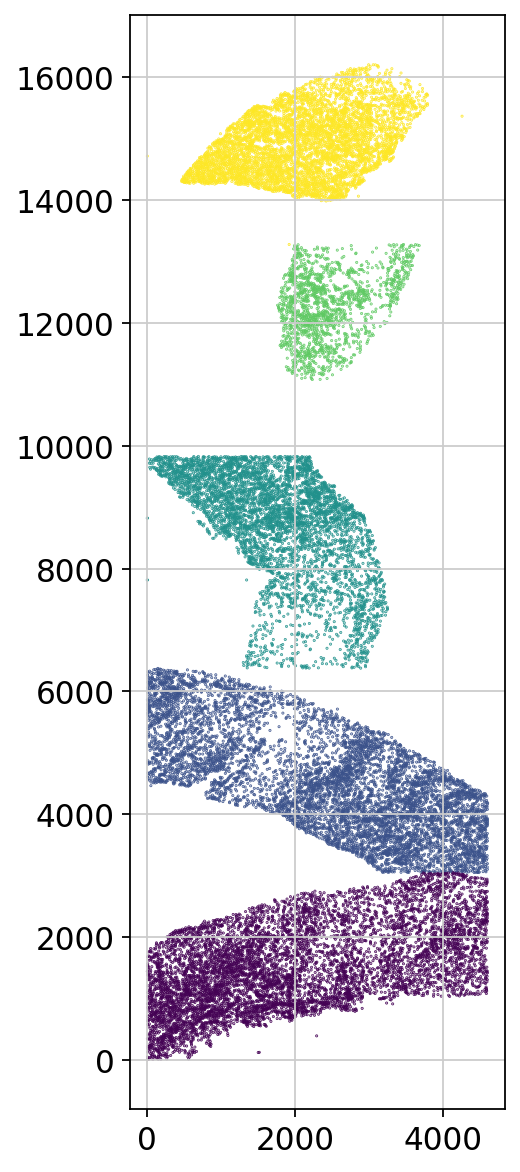

In [77]:
fig,ax=plt.subplots(figsize=(3,9))
ax=plt.scatter(loc.xcoord,loc.ycoord,c=loc.region,s=0.1)

### Display the sc/sn data for individual samples

In [16]:
adatas = {}
for sample in sorted(sample_sheet['sample'].unique()):
    print(sample)
    adata=sc.read_h5ad(out_dir+"/"+sample+"/"+sample+"_scRNAseq.h5ad")
    counts = adata.X
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    norm = adata
    adata.layers["counts"] = counts
    adata.raw = norm
    del counts
    del norm
    sc.pp.highly_variable_genes(adata,layer="counts",flavor='seurat_v3',n_top_genes=5000, batch_key="replicate")
    if len(adata.obs['replicate'].unique()) > 1:
        adata.var['highly_variable']= adata.var['highly_variable_nbatches']>1
    adata = adata[:, adata.var['highly_variable']]
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']);
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata,random_state=42,n_neighbors=20)
    sc.tl.leiden(adata,random_state=42)
    sc.tl.umap(adata,random_state=42)
    adatas[sample] = adata

HTAPP-213-SMP-6752
HTAPP-313-SMP-932
HTAPP-330-SMP-1082
HTAPP-364-SMP-1321
HTAPP-514-SMP-6760
HTAPP-783-SMP-4081
HTAPP-812-SMP-8239
HTAPP-853-SMP-4381
HTAPP-878-SMP-7149
HTAPP-880-SMP-7179
HTAPP-895-SMP-7359
HTAPP-917-SMP-4531
HTAPP-944-SMP-7479
HTAPP-982-SMP-7629
HTAPP-997-SMP-7789


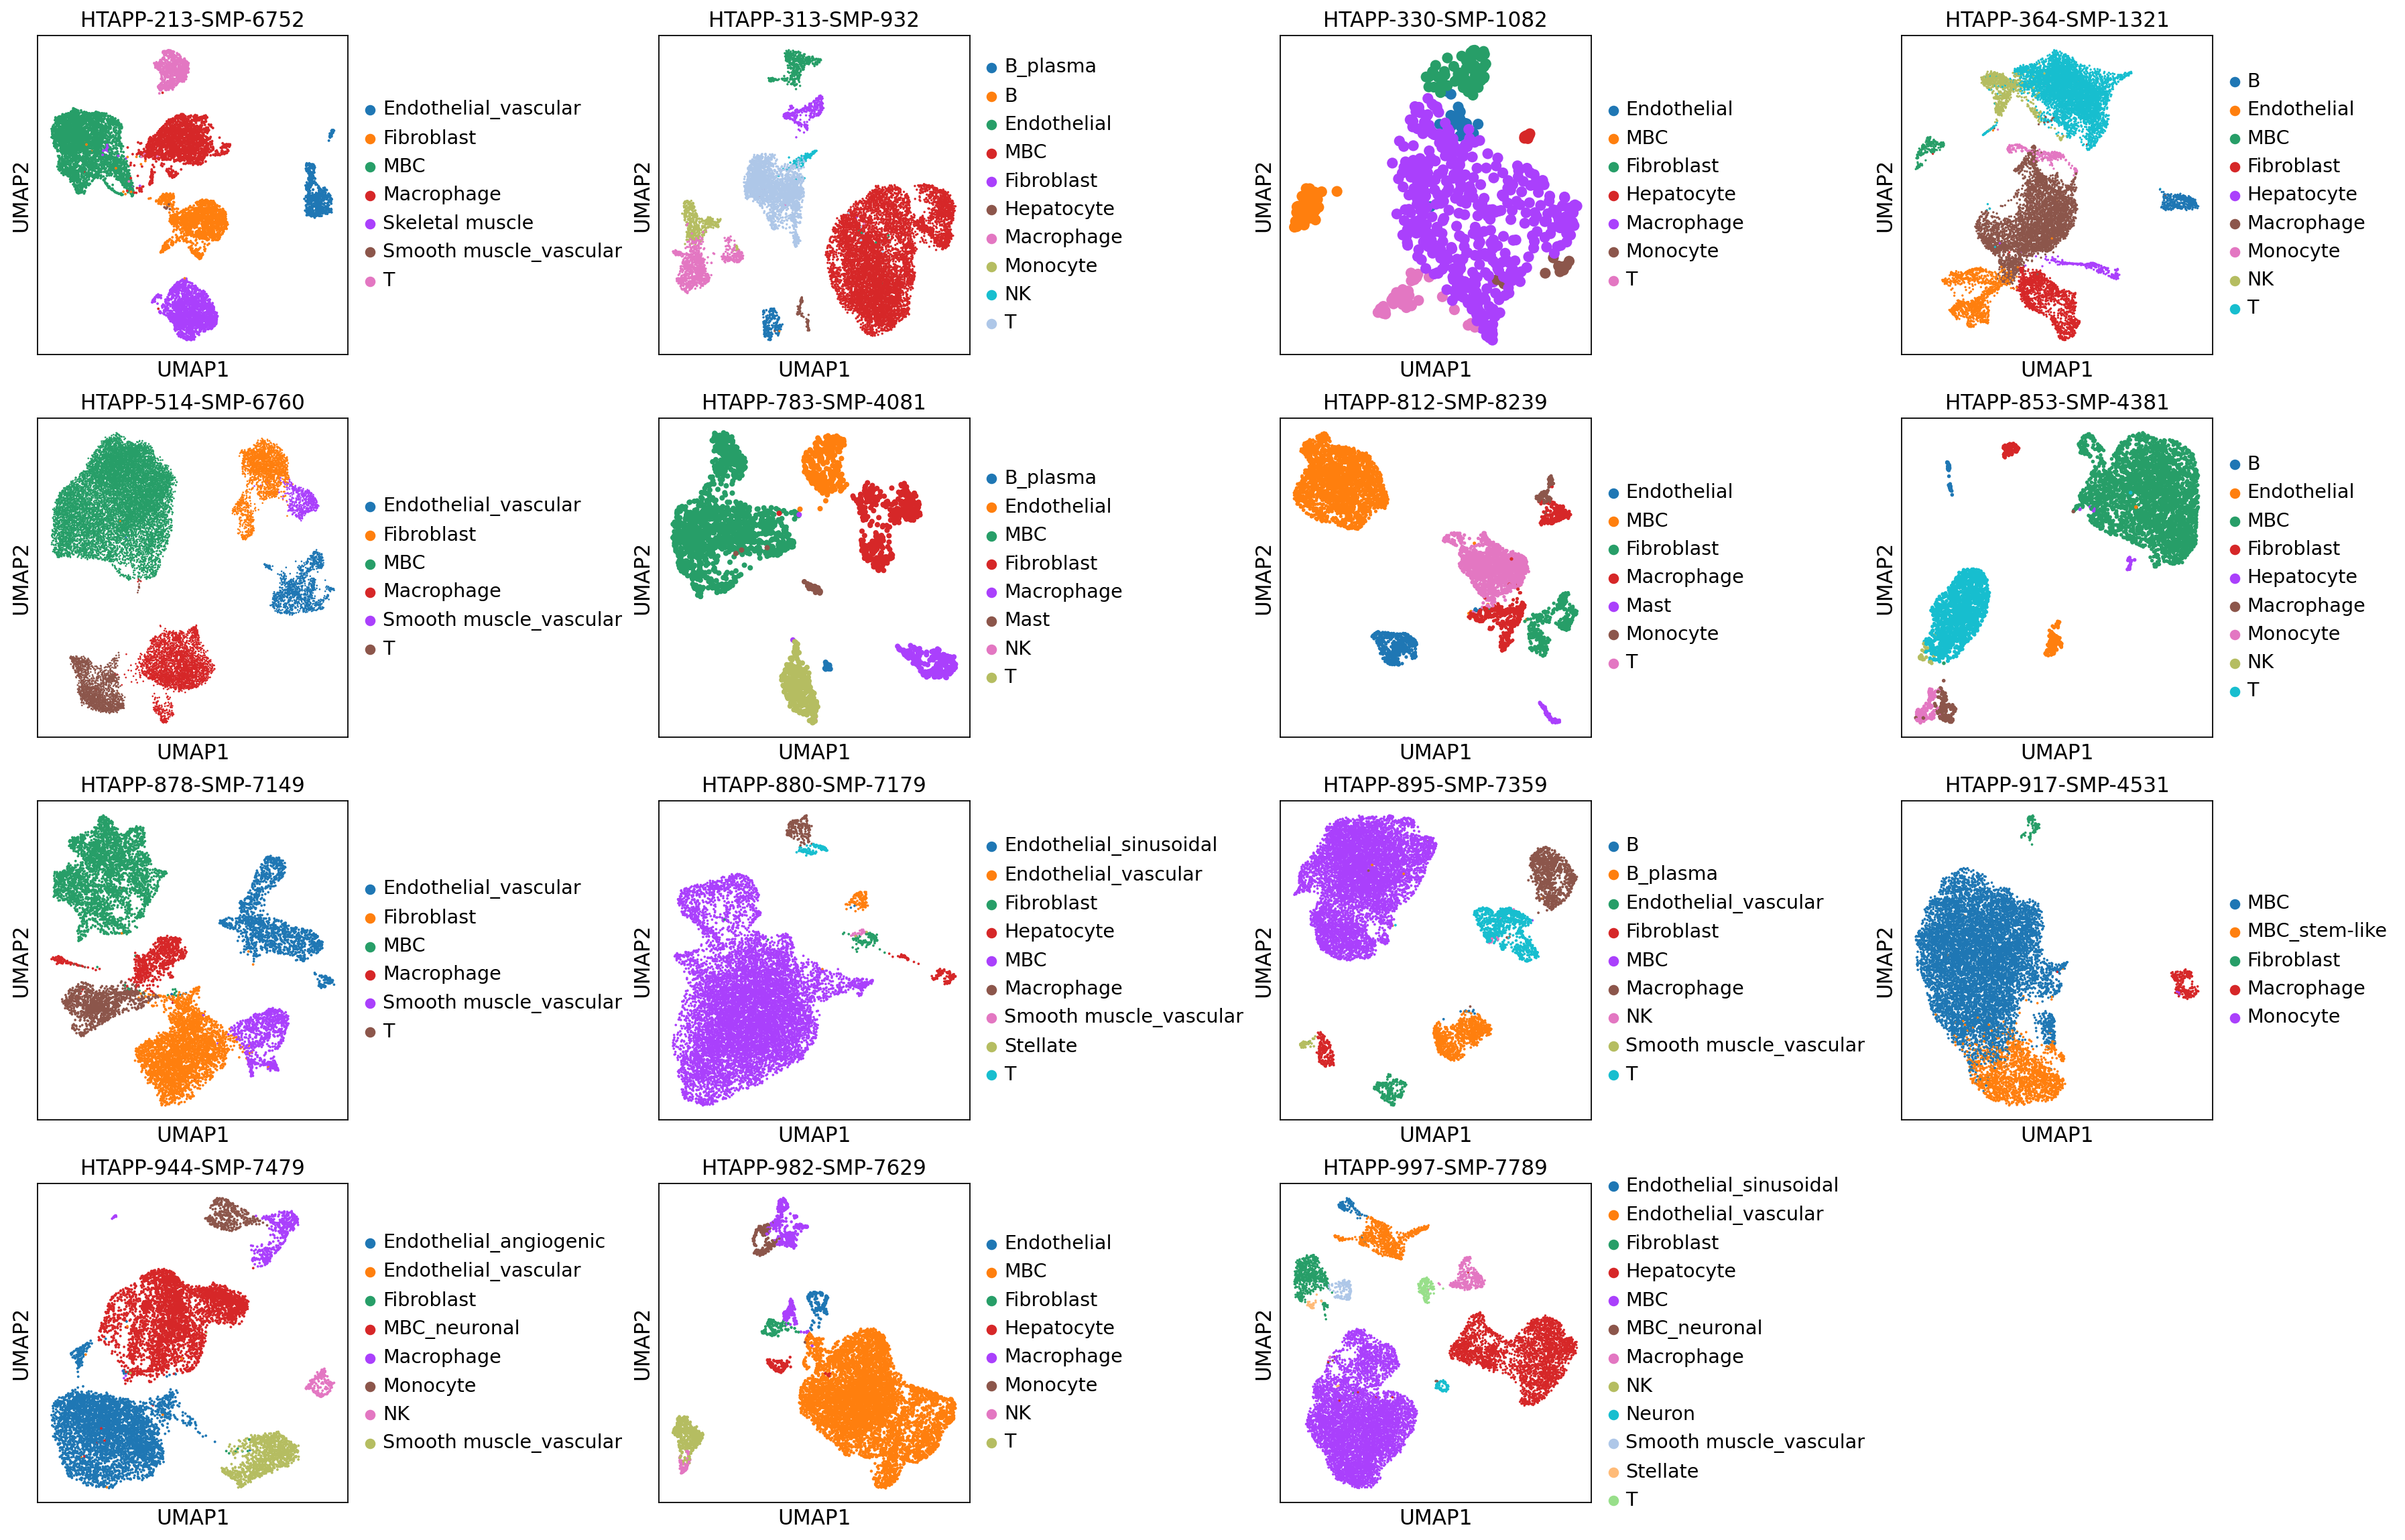

In [18]:
fig,axs=plt.subplots(4,4,figsize=(26,18),gridspec_kw={'wspace':1.0})
axs=np.array(axs).flatten();
for i,(l,adata) in enumerate(adatas.items()):
    sc.pl.umap(adata, color=['cell_type'], ax=axs[i], show=False);
    axs[i].set_title(l)
for ax in axs[len(adatas):]:
    ax.set_axis_off()

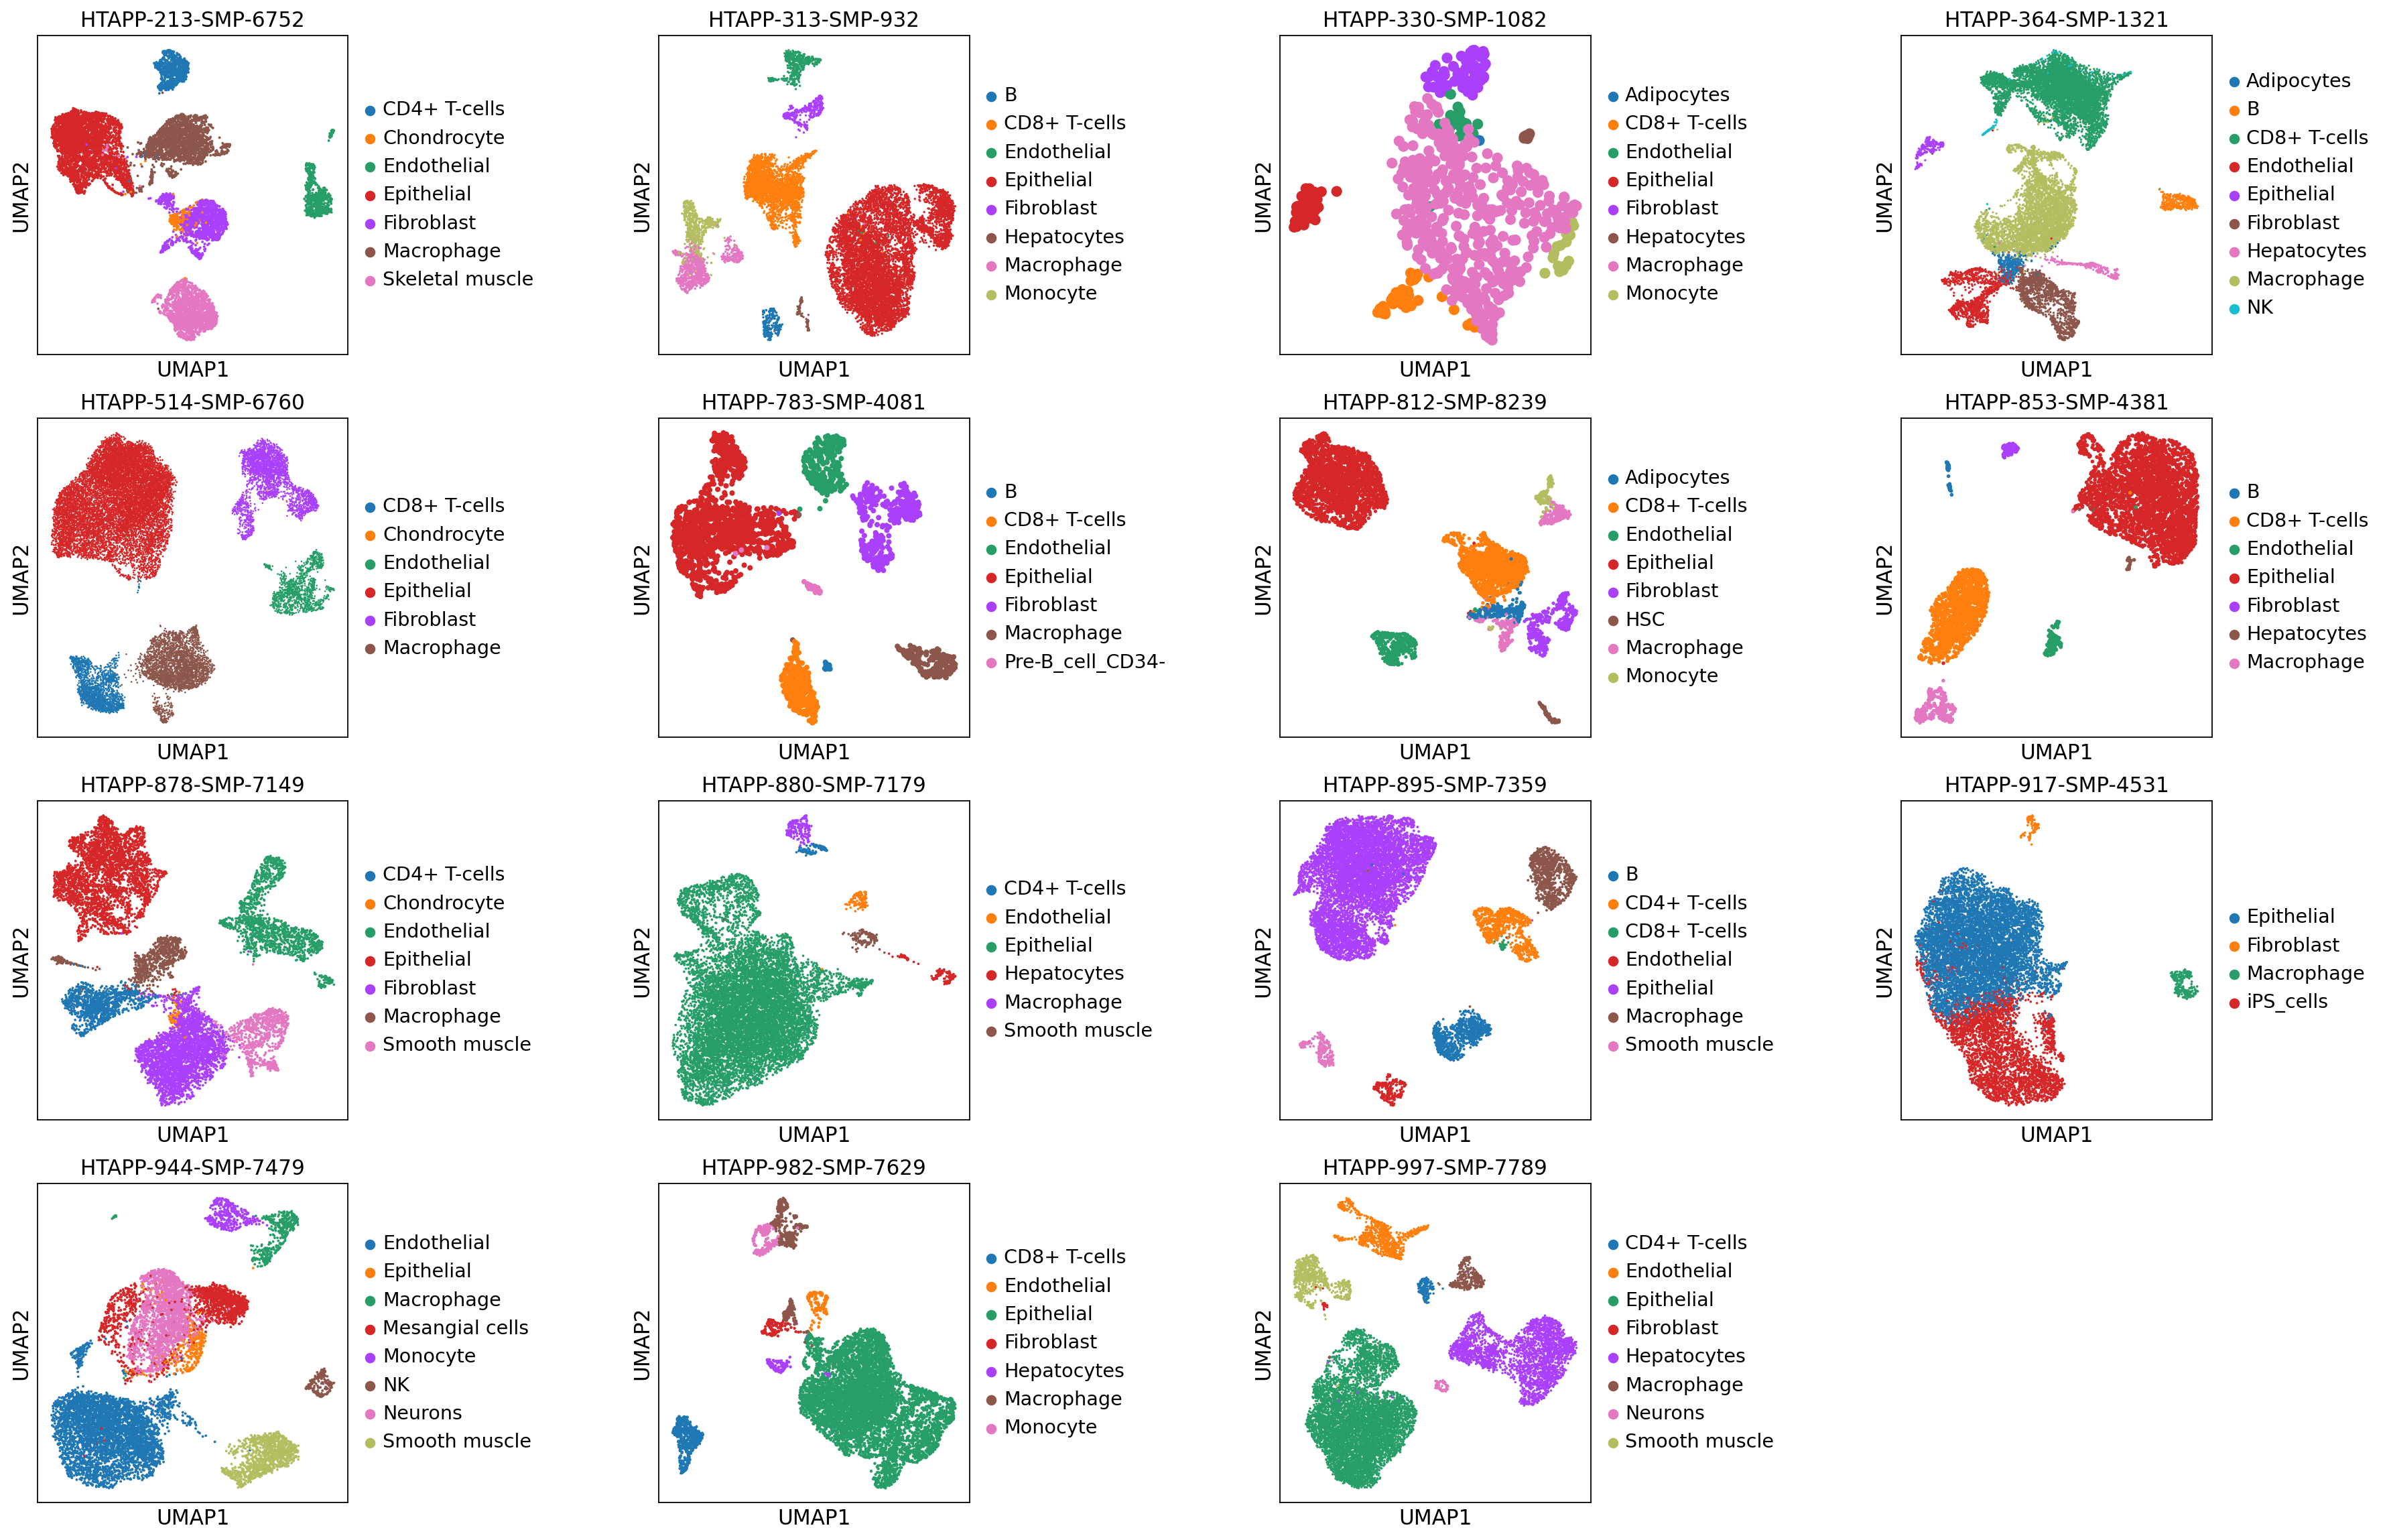

In [19]:
fig,axs=plt.subplots(4,4,figsize=(26,18),gridspec_kw={'wspace':1.0})
axs=np.array(axs).flatten();
for i,(l,adata) in enumerate(adatas.items()):
    sc.pl.umap(adata, color=['labels_cl_unif'], ax=axs[i], show=False);
    axs[i].set_title(l)
for ax in axs[len(adatas):]:
    ax.set_axis_off()

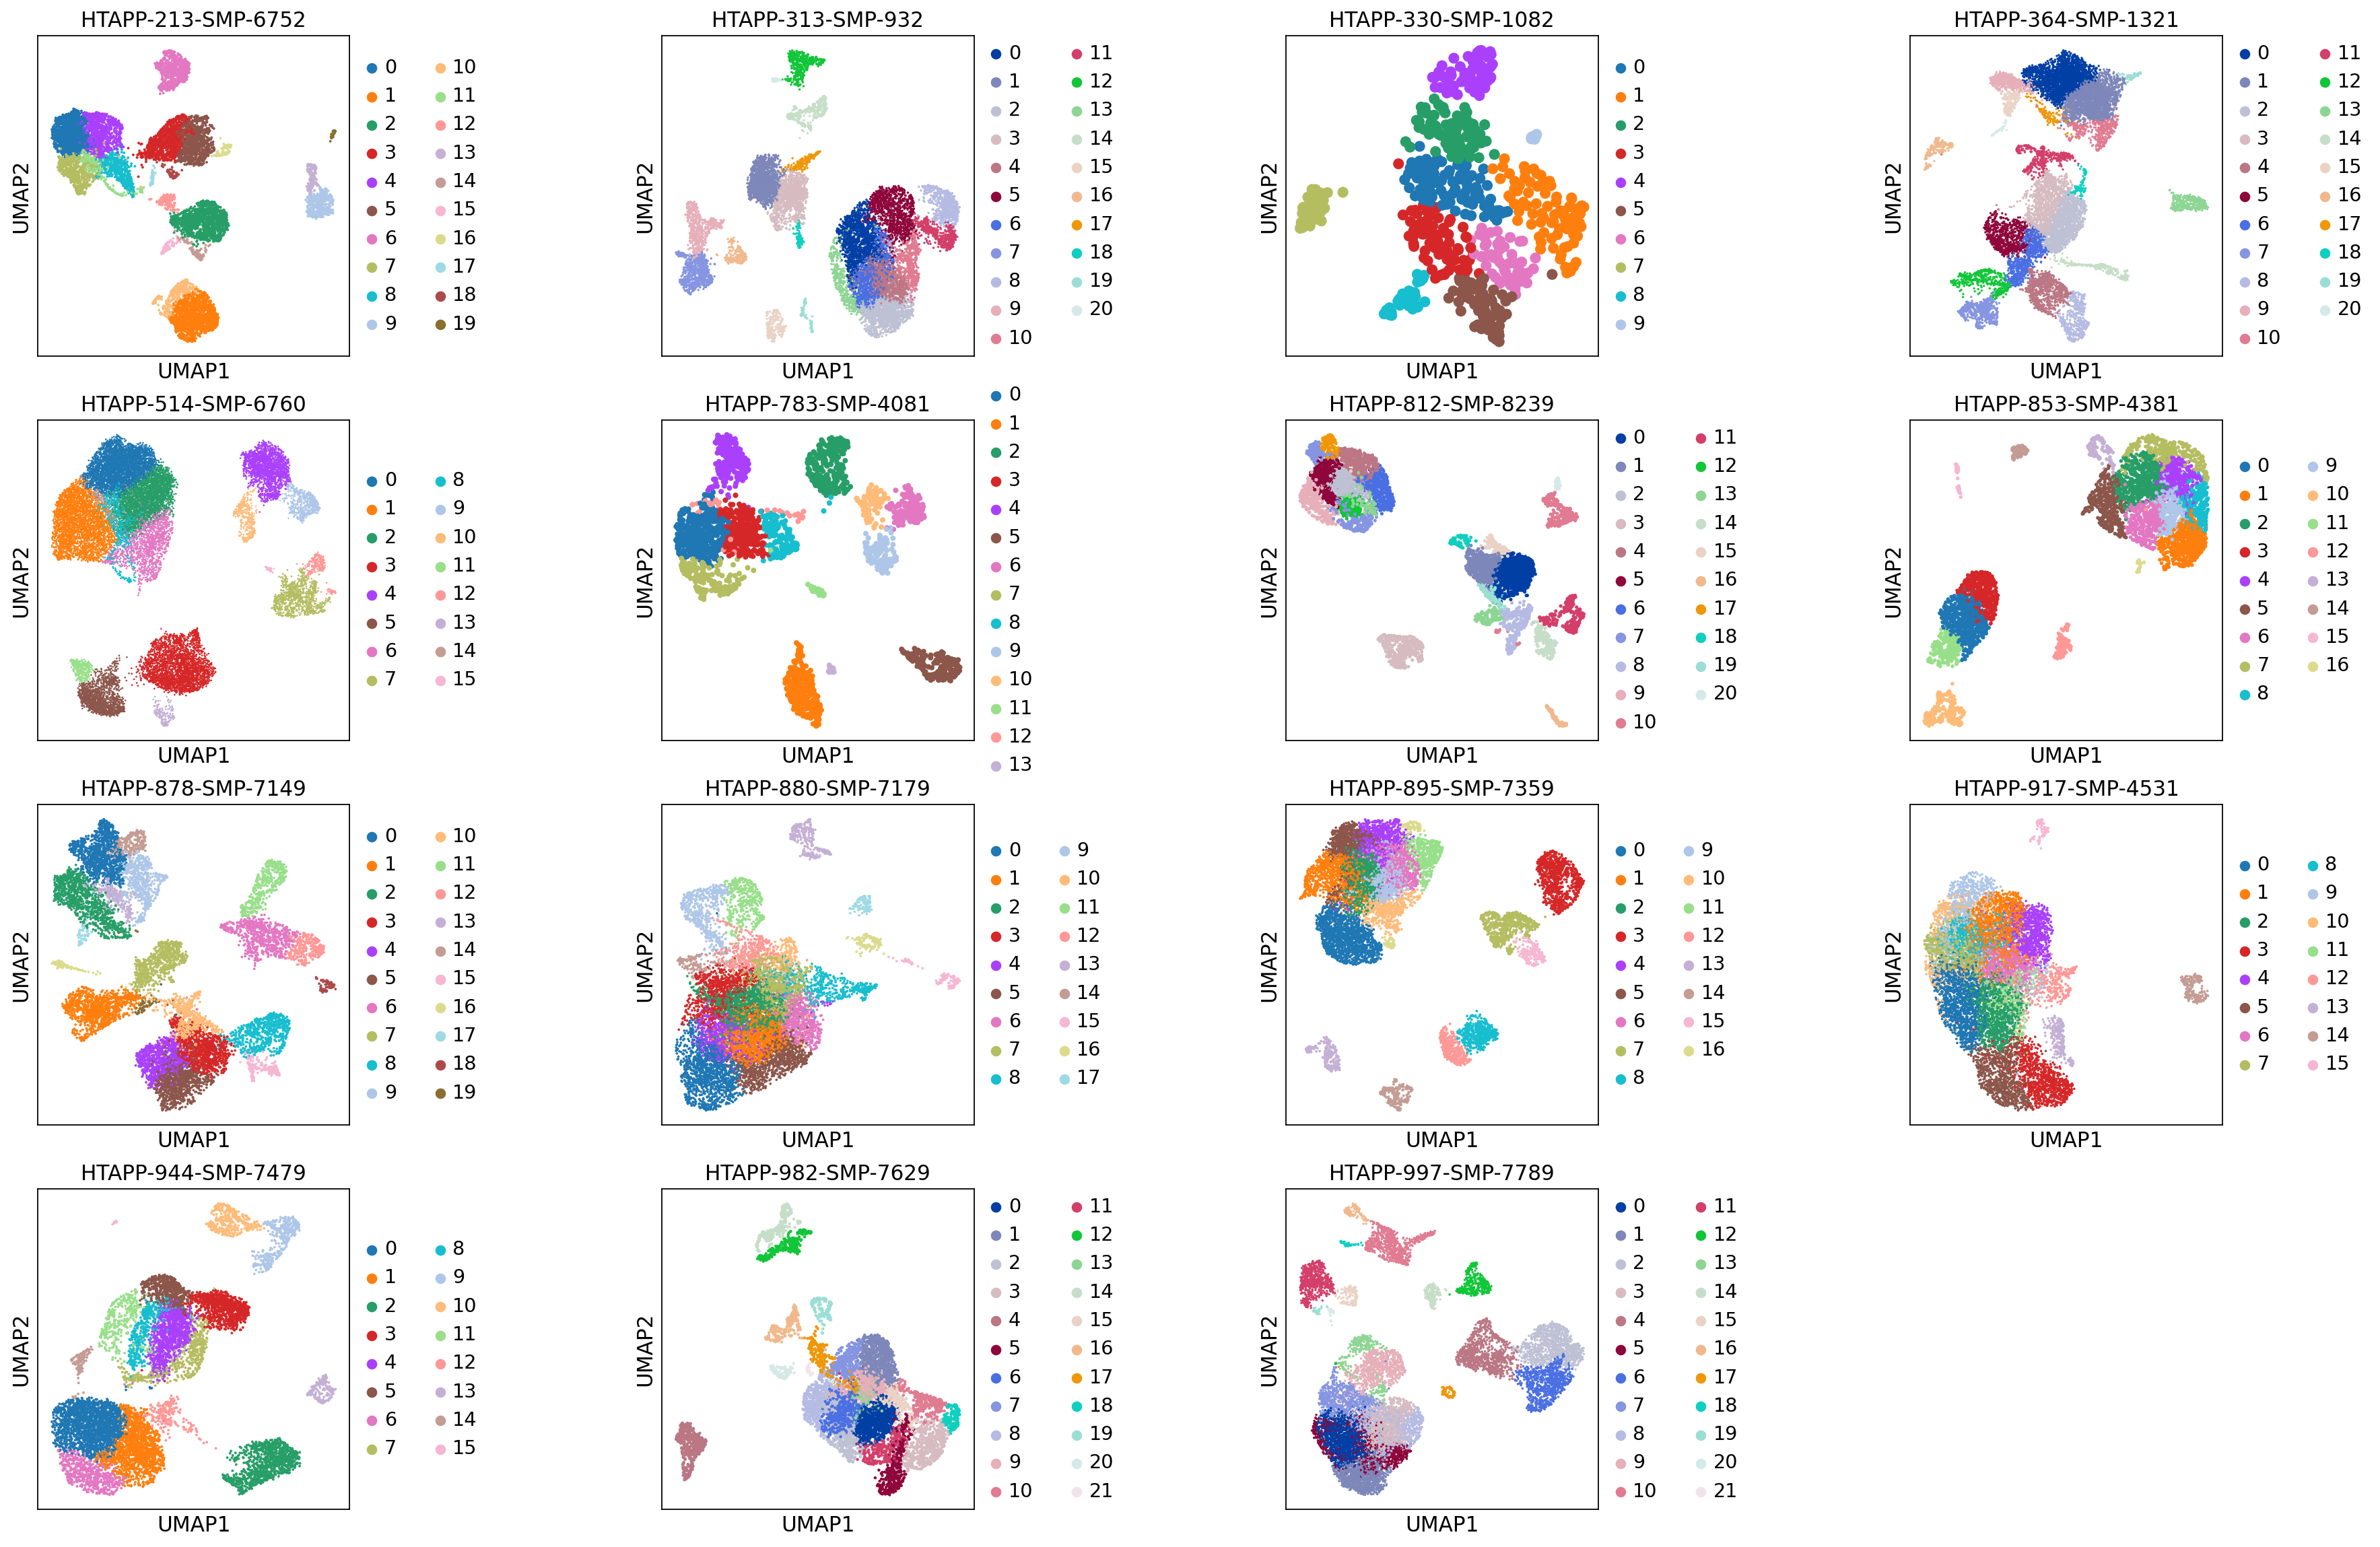

In [20]:
fig,axs=plt.subplots(4,4,figsize=(26,18),gridspec_kw={'wspace':1.0})
axs=np.array(axs).flatten();
for i,(l,adata) in enumerate(adatas.items()):
    sc.pl.umap(adata, color=['leiden'], ax=axs[i], show=False);
    axs[i].set_title(l)
for ax in axs[len(adatas):]:
    ax.set_axis_off()

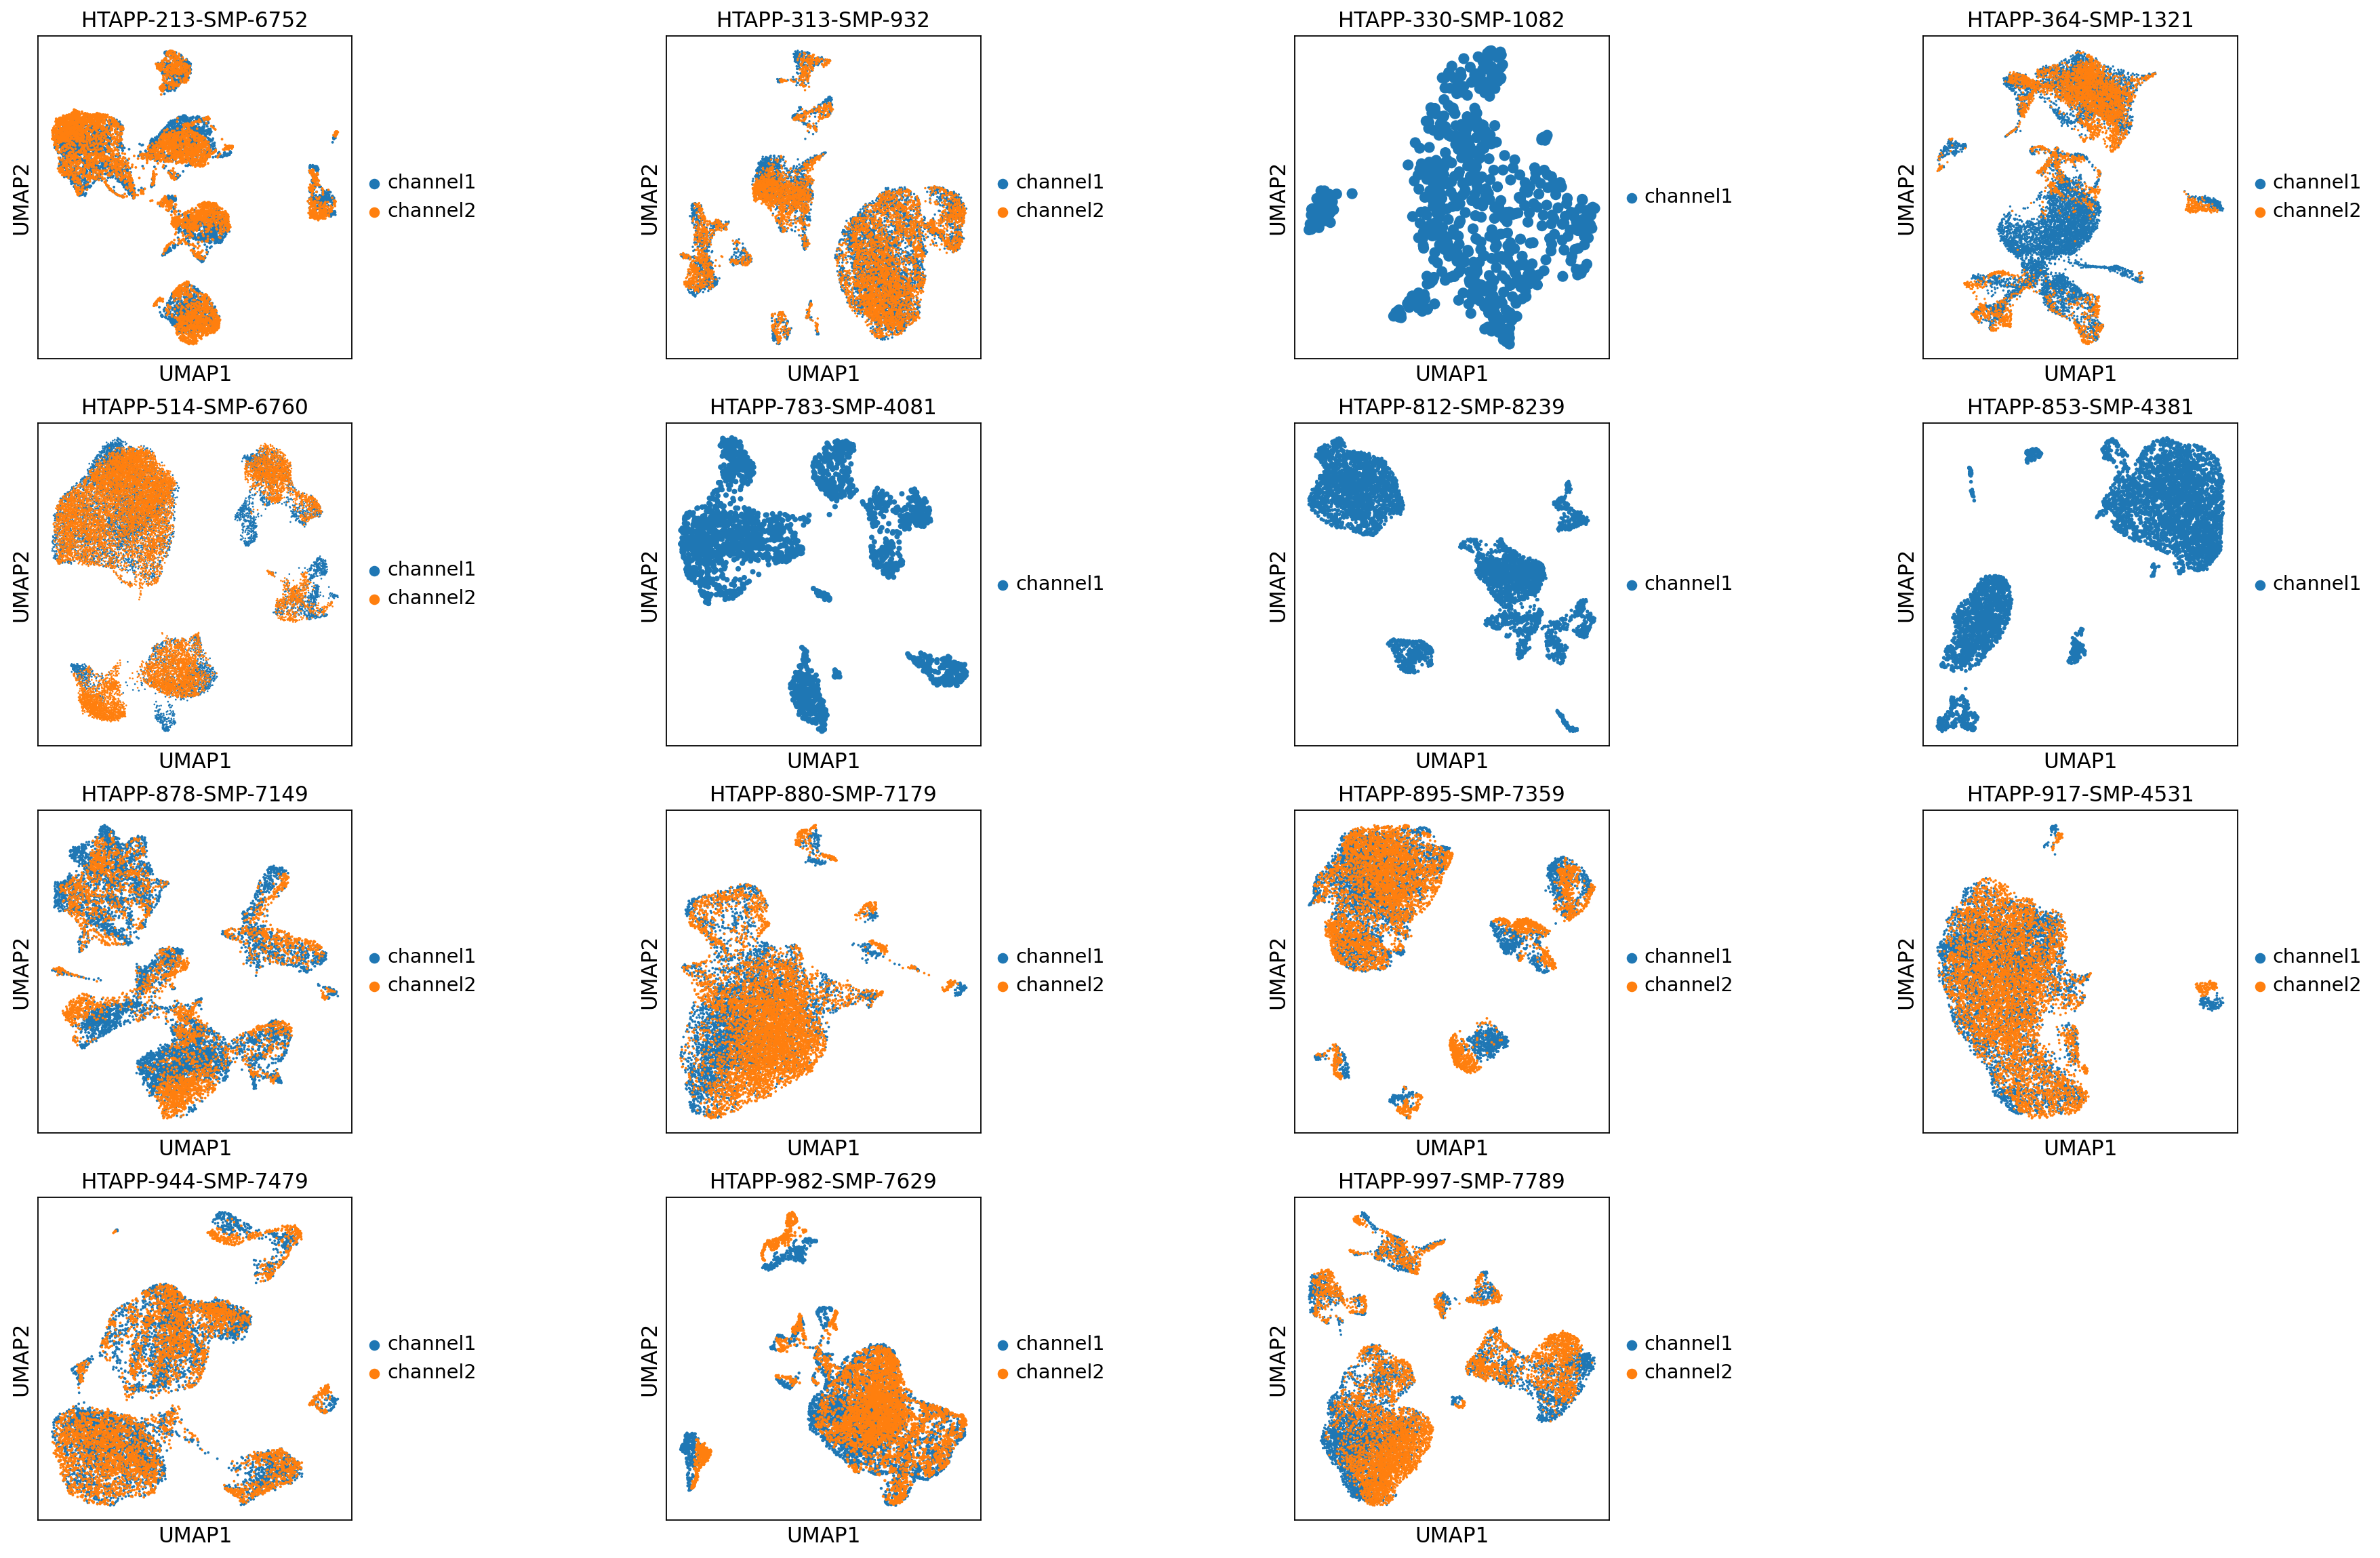

In [21]:
fig,axs=plt.subplots(4,4,figsize=(26,18),gridspec_kw={'wspace':1.0})
axs=np.array(axs).flatten();
for i,(l,adata) in enumerate(adatas.items()):
    sc.pl.umap(adata, color=['replicate'], ax=axs[i], show=False);
    axs[i].set_title(l)
for ax in axs[len(adatas):]:
    ax.set_axis_off()